<a href="https://colab.research.google.com/github/LiYuan199701/AMIC/blob/main/regression_wine_AMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two layer implementation of AMIC

## Basic package loading and import torch

In [1]:
import pyximport
import os
import IPython
import Cython
import sys
import os
import numpy as np
import pandas as pd
import copy
import scipy
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random, math, sys, string, re
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 100  # Set dpi to 200 for high resolution

# Import keras and tensorflow
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.sequence import pad_sequences

# Split dataset into train, val, test
from sklearn.model_selection import train_test_split

# Import Torch Package and its functions

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.__version__

'2.6.0+cu124'

## Mount Google Driver, Read in Data Set from my Google Driver

In [2]:
%%time
# Mount Google Driver
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change to my project directory
os.chdir('/content/drive/MyDrive/AMIC project')

'''
# Read in original wine review data
old = pd.read_excel('./data/05_16_9reviewer.xlsx', index_col=0)
# Select columns: rating and Clean_desc
old = old[['rating', 'Clean_desc', 'review_year']]
'''

# Read in new wine review data "wine_review_cleaned.csv"
new = pd.read_csv('./data/wine_review_cleaned.csv', index_col=0)
# Select columns: score and description
new = new[['score', 'description', 'vintage_info']]
# Filter rows in 'new' where 'vintage_info' contains "reviewed"
new = new[new['vintage_info'].str.contains("reviewed", na=False)]
# Rename columns
new.columns = ['rating', 'Clean_desc', 'review_year']

'''
# --- Start of Added/Modified Code ---

# Convert the 'rating' columns to numeric, coercing errors to NaN
old['rating'] = pd.to_numeric(old['rating'], errors='coerce')
new['rating'] = pd.to_numeric(new['rating'], errors='coerce')
'''

# Drop rows with NaN values in the 'rating' column after coercion
# old.dropna(subset=['rating'], inplace=True)
new.dropna(subset=['rating'], inplace=True)

# --- End of Added/Modified Code ---

# row bind old and new
# df = pd.concat([old, new], axis=0)

# Randomly select 2000 rows from df
# df = df.sample(n=2000, random_state=42)

#print("old shape:", old.shape)
print("new shape:", new.shape)
#print("df shape:", df.shape)

df = new

df.head()

Mounted at /content/drive


<timed exec>:16: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.


new shape: (13818, 3)
CPU times: user 3.81 s, sys: 409 ms, total: 4.22 s
Wall time: 20 s


<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,rating,Clean_desc,review_year
wine_id,,,
1315550,80,Hints of strawberry and apricot fruit mix with...,NV (reviewed 2024)
1298869,80,"A bit disjointed, with an acidic frame that is...",NV (reviewed 2023)
1289167,80,"Soft and simple, with notes of cherry and rhub...",NV (reviewed 2022)
1277786,80,"A straightforward sparkler, with snappy acidit...",NV (reviewed 2021)
1277876,79,"A crisp sparkler, with notes of candied cherry...",NV (reviewed 2021)


# Creat the training, validation and test index

In [3]:
%%time
# Shuffle the wine review dataset
ds=df.sample(frac=1, random_state=42).copy()

# reset index for ds
ds = ds.reset_index(drop=True)

# Create an index column in ds that holds the original index values
ds['index'] = ds.index

# assign y to be the continuous variable rating
y = ds['rating'].values

# assign y to be the binary variable greater than 89
#y = (ds['rating']>89).astype(int).values

# Set a seed to torch functions for reproduce
SEED = 2022
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

indices = range(len(y))
train_index, valid_index = train_test_split(indices, test_size=0.1, random_state = SEED)
valid_index, test_index = train_test_split(valid_index, test_size=0.5, random_state = SEED)

print("train_index: ",train_index)
print("valid_index: ",valid_index)
print("test_index: ",test_index)

train_index:  [2155, 1057, 4014, 8677, 7879, 9187, 685, 81, 7911, 7125, 5425, 2408, 939, 3382, 10803, 1951, 6078, 10372, 13672, 12873, 6241, 4378, 11005, 12248, 12346, 579, 4772, 13669, 2990, 2966, 8884, 5516, 13413, 5134, 1758, 212, 11441, 12922, 13038, 107, 8923, 12845, 5122, 11670, 13684, 1620, 6706, 78, 11436, 5696, 7495, 12923, 5255, 6356, 4882, 10382, 6468, 10339, 1172, 782, 4392, 8174, 11367, 6877, 6056, 13272, 2032, 4454, 10259, 6532, 6817, 11786, 5272, 4700, 11118, 13064, 11762, 10147, 3657, 4310, 6857, 3599, 10257, 10049, 11181, 10221, 5792, 13680, 9302, 13008, 2120, 8279, 12342, 900, 1981, 2178, 5152, 10271, 11530, 8484, 4961, 3240, 7936, 7105, 3597, 1395, 10980, 1110, 13123, 2316, 11361, 11077, 4533, 63, 7590, 1952, 1017, 6739, 8543, 13389, 10109, 9342, 6450, 7699, 4109, 2117, 10492, 2838, 6347, 9222, 7792, 3982, 8299, 12712, 1174, 2296, 12975, 7209, 5873, 587, 10214, 9055, 11107, 12769, 12473, 11487, 13067, 3062, 11368, 10163, 765, 4684, 9333, 9416, 13567, 5040, 7826, 1245

## Creat a tokenizer object and word index

In [4]:
%%time
# concatenate the new['replaced'] into the ds['Clean_desc']
#combo = pd.concat([ds['Clean_desc'], new['replaced']], axis=0)

#tokenizer = Tokenizer(num_words=max_features)
maxlen=150
tokenizer = Tokenizer()
#Indexing words based on the whole corpus (prior to split)
tokenizer.fit_on_texts(ds['Clean_desc'])
#tokenizer.fit_on_texts(ds['clean_desc_v5'])
wine_corpus= tokenizer.texts_to_sequences(ds['Clean_desc'])
#wine_corpus= tokenizer.texts_to_sequences(ds['clean_desc_v5'])
train_word_index=tokenizer.word_index

CPU times: user 598 ms, sys: 6.26 ms, total: 604 ms
Wall time: 603 ms


## Create an id and word dictionary

In [5]:
tokenizer.word_index
wine_id2word=dict(zip(tokenizer.word_index.values(),tokenizer.word_index.keys()))
# Display
dict(list(wine_id2word.items())[:10])

{1: 'and',
 2: 'a',
 3: 'cases',
 4: 'with',
 5: 'drink',
 6: 'now',
 7: 'of',
 8: 'the',
 9: 'flavors',
 10: 'made'}

## Initialize a word embedding dictionary with a pretrained word embedding file

In [7]:
%%time
#change directory to your glove 300 location
embeddings_index = {}
GLOVE_DIR='./data'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.
CPU times: user 23.3 s, sys: 1.01 s, total: 24.3 s
Wall time: 25.5 s


## Create an embedding matrix for unique words

In [8]:
%%time
#embedding_size=50
embedding_size=300
word_index = list(tokenizer.word_index.keys())
miss_index =[]
miss_word = []
print('Found %s unique tokens.' % len(word_index), "\n")

embedding_matrix = np.zeros((len(word_index), embedding_size))
for i,word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
      # words not found in embedding index will be all-zeros.
        miss_word.append(word)
        miss_index.append(i)
print(embedding_matrix.shape, "\n")
print("Word Index list: ", word_index[:5], "\n")

Found 6171 unique tokens. 

(6171, 300) 

Word Index list:  ['and', 'a', 'cases', 'with', 'drink'] 

CPU times: user 13.5 ms, sys: 5.04 ms, total: 18.6 ms
Wall time: 18.4 ms


# Print out the Embedding Matrix

In [9]:
# Display the first word embeddings for the first few dimensions
print(embedding_matrix[:1][0][:20])

[ 0.038466   -0.039792    0.082747   -0.38923001 -0.21431001  0.17020001
 -0.025657    0.09578     0.2386     -1.63419998  0.14331999 -0.037958
 -0.019583    0.38494     0.097319    0.29697001 -0.34523001  0.11742
 -0.024189    0.16012999]


## Convert Corpus ids into words

In [10]:
%%time
#changed to 1 index
new_index = [x for x in list(range(len(word_index))) if x not in miss_index]
new_vocab = [x for x in list(word_index) if x not in miss_word]
new_vocab_dict = dict(zip(new_vocab,range(1,len(new_vocab)+1)))

def sent_id2word(corpus,id2word):
    output=[]
    for doc in corpus:
        temp = [id2word.get(x) for x in doc]
        output.append(temp)
    return output

wine_sents = sent_id2word(wine_corpus,wine_id2word)
# Demo for 1st sentence tokoen sequence
print("Wine Sentence Token: ", wine_sents[:1], "\n")

Wine Sentence Token:  [['this', 'creamy', 'cava', 'is', 'enlivened', 'by', 'citrusy', 'acidity', 'and', 'flavors', 'of', 'pickled', 'ginger', 'melon', 'ball', 'and', 'thai', 'basil', 'easy', 'drinking', 'with', 'a', 'fresh', 'zesty', 'finish', 'of', 'moderate', 'length', 'drink', 'now', '100', '000', 'cases', 'made', '100', '000', 'cases', 'imported']] 

CPU times: user 97.6 ms, sys: 1.94 ms, total: 99.5 ms
Wall time: 99.3 ms


## Remove words that are not in embedding matrix

In [11]:
%%time
## remove word in not in the embedding matrix
new_wine_sents = []
new_vocab_id2word = dict(zip(new_vocab_dict.values(),new_vocab_dict.keys()))

for doc in wine_sents:
    temp = [x for x in doc if x in new_vocab]
    new_wine_sents.append(temp)
## retokenize with new_vocab_dict that is zero indexed
new_wine_sents_id = []
for doc in new_wine_sents:
    temp = [new_vocab_dict.get(x) for x in doc]
    new_wine_sents_id.append(temp)

new_wine_sents[0]

CPU times: user 1.44 s, sys: 6.5 ms, total: 1.45 s
Wall time: 1.44 s


['this',
 'creamy',
 'cava',
 'is',
 'enlivened',
 'by',
 'citrusy',
 'acidity',
 'and',
 'flavors',
 'of',
 'pickled',
 'ginger',
 'melon',
 'ball',
 'and',
 'thai',
 'basil',
 'easy',
 'drinking',
 'with',
 'a',
 'fresh',
 'zesty',
 'finish',
 'of',
 'moderate',
 'length',
 'drink',
 'now',
 '100',
 '000',
 'cases',
 'made',
 '100',
 '000',
 'cases',
 'imported']

## Make a new embedding matrix for all existing words

In [12]:
%%time
word_index = list(new_vocab_dict.keys())
miss_index =[]
miss_word = []
print('Found %s unique tokens.' % len(word_index))


embedding_matrix = np.zeros((len(word_index), embedding_size))
for i,word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        miss_word.append(word)
        miss_index.append(i)
print(embedding_matrix.shape)
#print(sum(np.sum(embedding_matrix,axis = 0 )==0))

Found 5704 unique tokens.
(5704, 300)
CPU times: user 11.8 ms, sys: 5.05 ms, total: 16.8 ms
Wall time: 16.6 ms


## Calculate the word length for each review

In [13]:
%%time
Corpus_cleaned = new_wine_sents
Corpus_cleaned_id = new_wine_sents_id
lengths = [len(x) for x in Corpus_cleaned_id]
lengths = np.array(lengths)
lengths = np.expand_dims(lengths, axis=1)
#nsize=5000
#text_10000 = Corpus_cleaned_id[0:nsize]+ Corpus_cleaned_id[::-1][0:nsize]
text_10000 = Corpus_cleaned_id

print("Show length vector: ", lengths, "\n")
print("Show token id for 1st sentence: ", Corpus_cleaned_id[0], "\n")
print("Show the Max token id of all corpus: ", max([max(x) for x in Corpus_cleaned_id]), "\n")

Show length vector:  [[38]
 [35]
 [20]
 ...
 [28]
 [18]
 [27]] 

Show token id for 1st sentence:  [14, 27, 335, 37, 691, 35, 244, 22, 1, 9, 7, 246, 31, 203, 1710, 1, 1711, 1368, 181, 281, 4, 2, 24, 188, 11, 7, 174, 196, 5, 6, 122, 13, 3, 10, 122, 13, 3, 12] 

Show the Max token id of all corpus:  5704 

CPU times: user 9.89 ms, sys: 0 ns, total: 9.89 ms
Wall time: 9.87 ms


### Plot a bar plot to show the distribution of y label

In [16]:
# convert y into numeric
y = pd.to_numeric(y)
# print statistical numbers of y
print("Mean of y:", np.mean(y))
print("Median of y:", np.median(y))
print("Standard deviation of y:", np.std(y))
print("Minimum of y:", np.min(y))
print("Maximum of y:", np.max(y))
min_value = np.min(y)
max_value = np.max(y)

Mean of y: 87.03553336228109
Median of y: 88.0
Standard deviation of y: 4.368166276464209
Minimum of y: 53
Maximum of y: 100


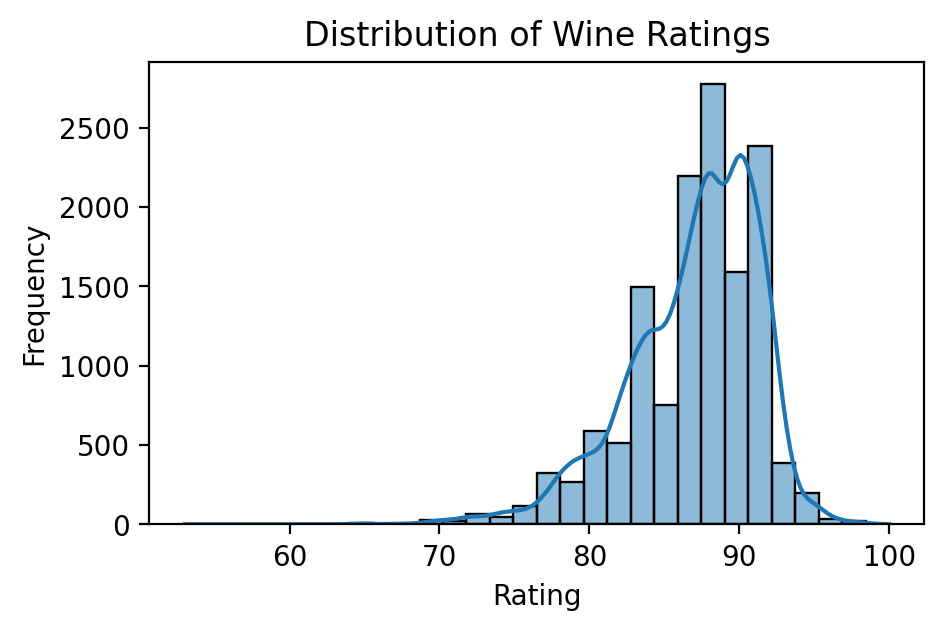

In [17]:
plt.figure(figsize=(5, 3))
sns.histplot(y, kde=True, bins=30)
plt.title('Distribution of Wine Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

## Define a function that either pads a review with zeros or truncate to a specific length

In [18]:
def pad_features(reviews_int, seq_length):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i,:] = np.array(new)

    return features

## Apply sequence length of 100 to uniform the all review lengths

In [19]:
%%time
pad_size = 100
padded_X = pad_features(text_10000, pad_size)
#padded_X = pad_features(text_10000,56)
print("outcome y label length: ", len(y), "\n")
print("Print padded Embedding shape: ", padded_X.shape, "\n")

outcome y label length:  13818 

Print padded Embedding shape:  (13818, 100) 

CPU times: user 154 ms, sys: 9.88 ms, total: 164 ms
Wall time: 163 ms


## Split the whole dataset into training, validation, and test: 18:1:1

In [20]:
# Set a seed to torch functions for reproduce
train_x = np.concatenate([padded_X[train_index],lengths[train_index]],axis = 1)
valid_x = np.concatenate([padded_X[valid_index],lengths[valid_index]],axis = 1)
test_x = np.concatenate([padded_X[test_index],lengths[test_index]],axis = 1)

train_y = (y[train_index])
valid_y = (y[valid_index])
test_y = (y[test_index])

print("train_x shape: ", train_x.shape)
print("train_y shape: ", train_y.shape)
print("valid_x shape: ", valid_x.shape)
print("valid_y shape: ", valid_y.shape)
print("test_x shape: ", test_x.shape)
print("test_y shape: ", test_y.shape)

train_x shape:  (12436, 101)
train_y shape:  (12436,)
valid_x shape:  (691, 101)
valid_y shape:  (691,)
test_x shape:  (691, 101)
test_y shape:  (691,)


## Convert Pandas frame into a Tensor datasets

In [21]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

## Convert Tensor Dataset into DataLoader with a batch size of 64

In [22]:
batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last = True)

## Obtain one batch of training data for demo display

In [23]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample Word ID Feature input size: ', sample_x.size()) # batch_size, seq_length
print('The first Sample X token ID input: \n', sample_x[0])
print()
print('Sample Y Label size: ', sample_y.size()) # batch_size
print('Sample Y Indicator for greater than 89: \n', sample_y)

Sample Word ID Feature input size:  torch.Size([64, 101])
The first Sample X token ID input: 
 tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  62,   1,  43,  14,  57,  87,  82, 326,  52,  65,   1,  29,
         15,   2,  36,  83, 163, 204,   5,   6, 108, 730,   3,  10, 108, 730,
          3,  12,  28])

Sample Y Label size:  torch.Size([64])
Sample Y Indicator for greater than 89: 
 tensor([86, 77, 88, 77, 89, 92, 90, 89, 90, 90, 88, 83, 87, 89, 83, 91, 86, 88,
        89, 92, 82, 87, 87, 85, 90, 91, 91, 89, 88, 93, 90, 90, 90, 84, 84, 85,
        89, 91, 88, 90, 82, 86, 88, 91, 85, 87, 89, 83, 69, 90, 90, 83, 78, 87,
        93, 8

## Define a function that creates a embedding layer object

In [24]:
def create_emb_layer(weights_matrix, non_trainable=True):

    num_embeddings, embedding_dim = pad_embedding_matrix.size()
    emb_layer = nn.Embedding.from_pretrained(pad_embedding_matrix)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

'''
def src_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def src_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
'''

"\ndef src_mask(sz):\n    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)\n    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))\n    return mask\n\ndef src_mask(sz):\n    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)\n    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))\n    return mask\n"

## Create a padded embedding matrix

In [25]:
print("Embedding Size: ", embedding_size, "\n")
print("Embedding Matrix Size: ", embedding_matrix.shape, "\n")
pad_embedding_matrix=np.concatenate((np.zeros(embedding_size).reshape(1,embedding_size), embedding_matrix),axis=0)
print("Embedding Matrix size with zero", pad_embedding_matrix.shape)
pad_embedding_matrix = torch.from_numpy(pad_embedding_matrix.astype(np.float32))

Embedding Size:  300 

Embedding Matrix Size:  (5704, 300) 

Embedding Matrix size with zero (5705, 300)


## Convert the tensor of token ID back to the word by the dictionary

In [26]:
# Convert the tensor of token ID back to the word by the dictionary
def sent_id2word(corpus, id2word):
    output=[]
    for doc in corpus:
        temp = [id2word.get(x) for x in doc]
        output.append(temp)
    return output

# Define a function that maps each token id to the word from a single tensor object
def rev_id2word(doc, id2word):
    return [id2word.get(x) for x in doc]

# Apply the sentence id to word function to the first part of each of dataiter
# rev_id2word(train_x[0], wine_id2word)

# Apply sent_id2word function to the train_data
word_train = sent_id2word(padded_X[train_index], wine_id2word)

# Save the word_train to the attention folder
#np.save('./attention/word_train.npy', word_train)

# print the length of word_train
print("Length of word_train: ", len(word_train))

Length of word_train:  12436


# 2-layer model structure

## Create a Self Attention class

In [27]:
class SelfAttention(nn.Module):
    """
    Canonical implementation of multi-head self attention.
    """
    def __init__(self, emb, heads=8, mask=False, reduced_dim=None):
        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()

        assert emb % heads == 0, f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'

        self.emb = emb
        self.heads = heads
        self.mask = mask

        s = emb // heads
        # - We will break the embedding into `heads` chunks and feed each to a different attention head

        self.tokeys    = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues  = nn.Linear(emb, emb, bias=False)

        self.unifyheads = nn.Linear(emb, emb)

        # Add projection layer if reduced_dim is specified
        if reduced_dim is not None:
            self.projection = nn.Linear(emb, reduced_dim)
        else:
            self.projection = None

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        s = e // h

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)



        keys    = keys.view(b, t, h, s)
        queries = queries.view(b, t, h, s)
        values  = values.view(b, t, h, s)

        # -- We first compute the k/q/v's on the whole embedding vectors, and then split into the different heads.
        #    See the following video for an explanation: https://youtu.be/KmAISyVvE1Y

        # Compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)

        out = self.unifyheads(out)

        # Apply projection if specified
        if self.projection is not None:
            out = self.projection(out)

        #return self.unifyheads(out)
        return out

## Define a tiedLinear Class

In [28]:
class tiedLinear(nn.Module):
    def __init__(self, in_features, bias=True):
        super(tiedLinear, self).__init__()
        self.in_features = in_features
        self.weight = Parameter(torch.Tensor(in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        repeated_weight = self.weight.repeat(self.in_features, 1)
        return F.linear(input, repeated_weight, self.bias)

## Define Positional Encoding class

In [29]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# model initilaization and training


## Define Mask Block class

In [30]:
class Mask_block(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot=0.5, drop_prob=0.5,num_heads=1, reduced_dim=100):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        embedding_dim = hidden_dim
        # embedding
        #   self.embedding, num_embeddings, embedding_dim =  create_emb_layer(weight_matrix, False)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layers
        self.fc1 = tiedLinear(reduced_dim, 1) #regular linear layer
        #self.fc1 = tiedLinear(embedding_dim) #tied linear layer
        #  self.pos_enc = PositionalEncoding(d_model = embedding_dim)
        self.attention1 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)
        self.attention2 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)
        #   self.re_pos_attention = MultiHeadAttentionLayer(hid_dim = embedding_dim, n_heads = self.num_heads, max_relative_position = max_relative_position )
        #self.fc2 = tiedLinear(embedding_dim, 1)
        #self.fc2 = nn.Linear(embedding_dim, 1)
        #self.fc2 = tiedLinear(embedding_dim, embedding_dim)
       # self.fc12 = nn.Linear(embedding_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
        self.leakyrelu = torch.nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        #self.pivot = torch.autograd.Variable(torch.rand(1), requires_grad=True)
        self.pivot = torch.tensor(pivot)

        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout10 = nn.Dropout(0.1)

    def forward(self, embeds, mask_1 ,digits):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = embeds.shape[0]

        # embeddings and lstm_out
        # author_embeds = self.author_embed(author)
        #primary instance
        # authors = torch.argmax(digits[:,0:8],dim =1)
        #   embeds = self.embedding(x)

        # embeds = self.pos_enc(embeds)
        #evaluting b
       # embeds = self.fc12(embeds)
        embeds = self.attention1(embeds)
        #       embeds = self.layer_norm(embeds)
        embeds = self.dropout10(embeds)

        # embeds = self.attention2(embeds)
        # embeds = self.layer_norm(embeds)
        # embeds = self.dropout10(embeds)

        mask  = self.fc1(embeds)
        mask  = torch.mean(mask,2)



        #mask = torch.sign(mask)
        mask = self.sig(mask)
        # mask  = torch.heaviside(mask,torch.tensor([0.5]).to(device))
        #mask = (torch.sign(self.tanh(mask)) +1) /2
        # mask  = torch.mean(mask,2)

        #mask = self.sig(mask)-0.5
        # mask = torch.add(mask,self.pivot)
        # mask  = self.relu(torch.sign(self.sig(mask)-self.pivot)) #try sigmoid


        mask_out = mask * mask_1
        # p3 = torch.norm(mask -2*self.relu(mask - 0.5),  p=1,dim=1)
        p3 = torch.norm( (mask * (1.0 - mask))**2,  p=1,dim=1 )
        p1 = torch.norm(mask, p=1, dim=1)

        return mask_out, p1 , p3, torch.mean(mask_out).detach().item()

In [31]:
class Sentiment_block(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers, max_relative_position= 2, pivot=0.5,drop_prob=0.5,num_heads=1, reduced_dim=100):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        embedding_dim = hidden_dim
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        self.dropout10 = nn.Dropout(0.1)
        # linear and sigmoid layers
        #self.fc = nn.Linear(embedding_dim, embedding_dim) #regular linear layer
        self.fc1 = tiedLinear(reduced_dim, 1) #tied linear layer
        self.fc3 = nn.Linear(1 + digits_dim, 1 )
        self.pos_enc = PositionalEncoding(d_model = embedding_dim)
        self.attention1 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)
        self.attention2 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)

    #    self.pos_attention = Pos_atten_1(hid_dim = embedding_dim, n_heads = self.num_heads )
      #  self.re_pos_attention = MultiHeadAttentionLayer(hid_dim = embedding_dim, n_heads = self.num_heads, max_relative_position = max_relative_position )
        self.fc2 = tiedLinear(reduced_dim)
       # self.fc12 = nn.Linear(embedding_dim, embedding_dim)
       # self.fc2 = nn.Linear(embedding_dim, 1)
        #self.fc2 = tiedLinear(embedding_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
        self.leakyrelu = torch.nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.layer_norm = nn.LayerNorm(reduced_dim)

    def forward(self, embeds ,mask_1 , mask, digits):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = embeds.shape[0]

        embdes = embeds * mask.ge(0.001).unsqueeze(2)
     #   author = torch.argmax(digits[:8])
        #embeds = self.pos_enc(embeds)
       # embeds = self.fc12(embeds)
        embeds = self.attention1(embeds)
        embeds = self.layer_norm(embeds)
        embeds = self.dropout10(embeds)

#         embeds = self.attention2(embeds)
#         embeds = self.layer_norm(embeds)
#         embeds = self.dropout10(embeds)
        # pos = (pos*mask_1).int()
        # pos = self.pos_embed(pos)
        # x3 = self.attention1(pos)
      #  x2 = self.pos_attention(embeds, mask_1, pos)


     #   out = self.fc2(0*x2 + 1* x3)
        save_out0 = embeds
        # print('embeddings size:', embeds.size())
        out = self.fc2(embeds)
        # print('out1 size: ', out.size())
        save_out = out
        out  = torch.mean(out, 2) # average out embedding dim
        # print('output out size: ', out.size())
        #out = self.tanh(out/10)
        # return last sigmoid output and hidden state

        return out, save_out, save_out0

In [32]:
class Synthesizer(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers, max_relative_position= 2, pivot=0.5,drop_prob=0.2,num_heads=1, reduced_dim=100):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        # embedding
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        self.fc2 = tiedLinear( hidden_dim)
        # linear and sigmoid layers
        #self.fc = nn.Linear(embedding_dim, embedding_dim) #regular linear layer
        self.fc1 = tiedLinear( hidden_dim, 1) #tied linear layer

       # self.pos_enc = PositionalEncoding(d_model = embedding_dim)
        self.attention = SelfAttention(emb =  hidden_dim, heads= self.num_heads, reduced_dim=reduced_dim)

       # self.re_pos_attention = MultiHeadAttentionLayer(hid_dim = embedding_dim, n_heads = self.num_heads, max_relative_position = max_relative_position )
        self.fc2 = tiedLinear( hidden_dim)
        self.fc3 = nn.Linear(1 + digits_dim, 1)
       # self.fc2 = nn.Linear(embedding_dim, 1)
        #self.fc2 = tiedLinear(embedding_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
        self.leakyrelu = torch.nn.LeakyReLU()
        #self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

        # Define the output linear layer
        #self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, sent, digits, mask, use_mask = False):

        #p2 = torch.norm(sent, p=2, dim=1)
      #  sent=self.tanh(sent)*5
        p2 = sent

        ###################
        '''
        for s in sent:
            print(s.size())
        for m in mask:
            print(m.size())
        '''
        ###################
      #  out = out * mask_1
        if use_mask == True:
            '''
            o1 = sent[0] * mask
            o2 = sent[1] * mask.unsqueeze(-1)
            o3 = sent[2] * mask.unsqueeze(-1)
            out = (o1, o2, o3)
            '''
            out = sent * mask
        else:
            out = sent

        save_out = out
     #   out = torch.multiply(out,mask)
        out = self.dropout(out)

        out = torch.mean(out,1)
        out = out.reshape((batch_size,1))

        #out  = torch.cat((out, digits), dim=1)
       # out  = self.fc3(out)
        #out = self.tanh(out)
        #out = torch.mean(out,1)
        # sigmoid function
        #sig_out = self.sig(out)
        # reshape to be batch_size first
        #sig_out = sig_out.view(batch_size, -1)
        #sig_out = sig_out[:, -1] # get last batch of labels

        #out = out.squeeze()  # remove extra dimension
        raw = out.squeeze()
        pred = torch.sigmoid(raw) * (max_value - min_value) + min_value

        # return last sigmoid output and hidden state
        return pred, p2, save_out

In [33]:
class Embeds(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.hidden_dim = hidden_dim
        # embedding False = trainable
        self.embedding, num_embeddings, embedding_dim =  create_emb_layer(weight_matrix, True)
       # self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.pos_enc = PositionalEncoding(d_model = hidden_dim)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
      #  mask = torch.transpose(mask,0,1)
        mask_1 = x.ge(0.1)
        #beta
       # x = (x * mask).int()
        embeds = self.embedding(x)
    #    embeds = self.pos_enc(embeds)
        # return last sigmoid output and hidden state
        return embeds, mask_1

# Instantiate the model w/ hyperparams

## Set up initial hyperparameters for neural network

In [34]:
vocab_size = len(new_vocab_dict)+1 # +1 for the 0 padding
embedding_dim = 300

digits_dim = 1 # 1 lengths
pivot = 0.5
hidden_dim = 300
n_layers = 2 #no use
num_heads = 10
#seed = 102003 #0.05
#seed = 102002 #0.09 5.05 pivot
#best seed = 42 0.51
#best seed = 42 p1*0.05 0007% organic
seed = 42 #0.92
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# intialization with the desired archtecture for GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

device = torch.device('cuda' if use_cuda else 'cpu')

train_on_gpu = use_cuda

True


## Initialize all needed objects from classes defined before

In [35]:
mb0 = Embeds(vocab_size, pad_embedding_matrix, hidden_dim)
mb1 = Sentiment_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads, reduced_dim=100)
mb2 = Mask_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads, reduced_dim=100)
mb3 = Synthesizer(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads, reduced_dim=100)

## Add Hook functions to extract the attention weights

In [36]:
activations_P = {}
def hook_fn_P(module, input, output):
    activations_P[module] = output

mb2.attention1.register_forward_hook(hook_fn_P)

activations_L = {}
def hook_fn_L(module, input, output):
    activations_L[module] = output

mb1.attention1.register_forward_hook(hook_fn_L)

## Training

training scheme

lr1 = 0.0005 #sentiment

lr2 = 0.00005 #mask

lr3 = 0.0005 #synthesizer

lr0 = 0.00005 #embeds


starts with negative penalty
then 0.03/batch_size
then 0.05 / batch_size at 88.5%




training scheme

lr1 = 0.0005 #sentiment
lr2 = 0.00005 #mask
lr3 = 0.0005 #synthesizer
lr0 = 0.00005 #embeds

starts with negative p1 p2^4 and p4 all times 0.01 untill

then positive p1 (e.g., 0.07) adding p2 till epoch 7 (highest accuracy) with mean_mask ~ 35%

can further increase coffecient of p2^4 to 1

can further increase coffecient of p2^4 to 1 15% mean mask, 88.4% accuracy

training scheme2 (88.7%)
start with negative p1 till mean mask high
then 0.01 p1 p2

then 0.1 p1 p

Training scheme after removing drink now made...
stgart with negative p1 p2 this makes mean-mask 1.0

with LR=0.005 and coeffieicnt p1 >0.002  p2 coef <<0.0002
this pushes the parameter off the local minimum and starts update masks
change lr to 0.002 with p1*0.002 p2 *0.004 train till optimal performances (?)

In [43]:
%%time
lr1 = 0.0002 #sentiment
lr2 = 0.0002 #mask
lr3 = 0.0002 #synthesizer
lr0 = 0.0002 #embeds

ss = 2
ga = 0.65

train_on_gpu = True
use_mask = True

#criterion = nn.BCELoss()
criterion = nn.MSELoss()  # Mean Squared Error for regression
# #criterion = nn.MSELoss()
optimizer1 = torch.optim.Adam(mb1.parameters(), lr=lr1, eps=1e-8)
optimizer2 = torch.optim.Adam(mb2.parameters(), lr=lr2, eps=1e-8)
optimizer3 = torch.optim.Adam(mb3.parameters(), lr=lr3, eps=1e-8)
optimizer0 = torch.optim.Adam(mb0.parameters(), lr=lr0, eps=1e-8)

scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=ss, gamma=ga)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=ss, gamma=ga)
scheduler3 = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=ss, gamma=ga)
scheduler0 = torch.optim.lr_scheduler.StepLR(optimizer0, step_size=ss, gamma=ga)

epochs = 15 # 3-4 is approx where I noticed the validation loss stop decreasing

lowest_loss = [100]
scale = 0.99

counter = 0
print_every = 20

clip=5 # gradient clipping

n_critic = 1

# move model to GPU, if available
if(train_on_gpu):
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)
    criterion.to(device)

mb1.train()
if use_mask == True:
    mb2.train()
else:
    mb2.eval()
mb3.train()
mb0.train()
# train for some number of epochs
train_l=[]
val_l = []

# Record all losses for plotting
all_epoch_train_loss = []
all_epoch_val_loss = []
#all_epoch_val_acc = []
all_epoch_val_mae = []  # Track Mean Absolute Error

for e in range(epochs):

    # initialize hidden state
    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler0.step()

    epoch_train_loss =[]
    epoch_val_loss = []
    #epoch_val_acc = []
    epoch_val_mae = []  # Track Mean Absolute Error
    masks = []

    # batch loop
    for batch_in, (inputs, labels) in  enumerate(train_loader):
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.to(device), labels.to(device)


        # zero accumulated gradients
        mb1.zero_grad()
        mb2.zero_grad()
        mb3.zero_grad()
        mb0.zero_grad()
        # get the output from the model
        inputs = inputs.type(torch.LongTensor).to(device)
        ### new stuff 5/25/2022
        texts, digits = inputs[:, 0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

        embeds, mask_1 = mb0(texts)
        mask_out, p1, p3, mean_mask = mb2(embeds, mask_1, digits)
        sent_out, save_out_sent, save_out0_sent = mb1(embeds, mask_1, mask_out, digits)
        ####################
        '''
        print(len(sent_out))
        print(len(mask_out))
        '''
        ####################
        output, p2, save_out = mb3(sent_out, digits, mask_out, use_mask)

        masks.append(mean_mask)

        mask_out  = mask_out.detach().to('cpu').numpy()
        save_out = save_out.detach().to('cpu').numpy()
        inputs_tmp = texts.to('cpu').numpy()

        l1_penalty=torch.zeros(1,requires_grad=True).to(device)
        for p in mb1.parameters():
            l1_penalty += p.abs().sum()*0.0000

        l2_penalty=torch.zeros(1,requires_grad=True).to(device)
        for p in mb1.parameters():
            l2_penalty += (p.pow(2.0).sum()) *0.0000

        for p in mb2.parameters():
            l1_penalty += p.abs().sum()*0.0000

        for p in mb2.parameters():
            l2_penalty += (p.pow(2.0).sum()) *0.0000
        #l 2_penalty = 0.001 * sum([(p**2).sum() for p in mb1.parameters()])
        # calculate the loss and perform backprop
        p4 = torch.norm(output,p=1)
        p2 = torch.norm(p2,p=2,dim = 1)

        loss = criterion(output.squeeze(), labels.float())
      #  loss_p = loss #+(torch.mean(p2*0.001)).squeeze() + (torch.mean(p4*0.001)).squeeze()
       # loss_p = loss + torch.mean(p1*0.03).squeeze()+ torch.mean(p3*0.06)
        loss_p = loss + torch.mean(p1*0.01).squeeze() + torch.mean((p3+1e-8).pow(0.5)*0.02)# +(torch.mean(p2*0.001)).squeeze() + (torch.mean(p4*0.001)).squeeze()

        if batch_in % n_critic != 0:
            loss_p.backward()
            optimizer2.step()
            optimizer3.step()
            optimizer0.step()
        if batch_in % n_critic == 0:
            # now back propagate to get derivatives
            loss_p.backward()
            # use gan optimizer to only update the parameters of the generator
            # this was setup above to only use the params of generator
            optimizer1.step()
            optimizer2.step()
            optimizer3.step()
            optimizer0.step()
        #val_losses = []
        # Validation section - updated for continuous output
        if counter % print_every == 0:
            mb1.eval()
            mb2.eval()
            mb3.eval()
            mb0.eval()

            val_losses = []
            val_maes = []  # Track Mean Absolute Error
            masks = []

            for val_i, (inputs, labels) in enumerate(valid_loader):
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor).to(device)
                texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)]

                embeds, mask_1 = mb0(texts)
                mask_out, p1, p3, mean_mask = mb2(embeds, mask_1, digits)
                sent_out, save_out_sent, save_out0_sent = mb1(embeds, mask_1, mask_out, digits)
                output, p2, save_out = mb3(sent_out, digits, mask_out, use_mask)

                # Mask processing remains the same
                mask_out = mask_out.detach()
                sums = 0
                word_c = 0
                for b_i in range(mask_out.shape[0]):
                    length = digits[b_i, digits_dim -1]
                    word_c += length
                    tmp = mask_out[b_i][(pad_size - length - 1):pad_size]
                    sums += torch.sum(tmp)
                mean_mask1 = (sums / word_c).cpu()
                masks.append(mean_mask1)

                # Calculate validation metrics
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

                # Calculate MAE (Mean Absolute Error)
                mae = torch.abs(output.squeeze() - labels.float()).mean().item()
                val_maes.append(mae)

            print(f'mean_mask: {mean_mask}; mean_mask1: {np.mean(masks)}; p1: {torch.mean(p1*1).squeeze()}; p2:{torch.mean(p2*1).squeeze()}')

            mb1.train()
            if use_mask == True:
                mb2.train()
            else:
                mb2.eval()
            mb3.train()
            mb0.train()

            print("Epoch: {}/{}...".format(e+1, epochs), "\n",
                  "Step: {}...".format(counter), "\n",
                  "Train Loss: {:.6f}...".format(loss.item()), "\n",
                  "Val Loss: {:.6f}".format(np.mean(val_losses)), "\n",
                  "Val MAE: {:.6f}".format(np.mean(val_maes)))  # New MAE metric

            epoch_train_loss.append(loss.to('cpu').item())
            epoch_val_loss.append(np.mean(val_losses))
            epoch_val_mae.append(np.mean(val_maes))  # Store MAE

            '''
            # Model saving logic remains the same
            if np.mean(val_losses) < (lowest_loss[-1])*scale:
                vers='new_best'
                PATH = f'/content/drive/MyDrive/AMIC project/{vers}_save'
                try:
                    os.mkdir(PATH)
                except:
                    print('exception occurred')
                os.chdir(PATH)

                model_name1 = f'three_block_mb1_{vers}'
                model_name2 = f'three_block_mb2_{vers}'
                model_name3 = f'three_block_mb3_{vers}'
                model_name0 = f'three_block_mb0_{vers}'
                save_path1 = model_name1 + '.pt'
                save_path2 = model_name2 + '.pt'
                save_path3 = model_name3 + '.pt'
                save_path0 = model_name0 + '.pt'

                torch.save(mb1.state_dict(), save_path1)
                torch.save(mb2.state_dict(), save_path2)
                torch.save(mb3.state_dict(), save_path3)
                torch.save(mb0.state_dict(), save_path0)
                lowest_loss.append(np.mean(val_losses))
                print(f"new best model saved with loss:{lowest_loss}")
            '''
    # Record all metrics
    all_epoch_train_loss.append(epoch_train_loss)
    all_epoch_val_loss.append(epoch_val_loss)
    all_epoch_val_mae.append(epoch_val_mae)  # Store MAE for each epoch

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


mean_mask: 0.226534903049469; mean_mask1: 0.7007411122322083; p1: 47.1617431640625; p2:4.645613193511963
Epoch: 1/15... 
 Step: 20... 
 Train Loss: 6.012249... 
 Val Loss: 6.538274 
 Val MAE: 1.700529
mean_mask: 0.2286083698272705; mean_mask1: 0.7111058235168457; p1: 48.08525466918945; p2:4.536301612854004
Epoch: 1/15... 
 Step: 40... 
 Train Loss: 7.362335... 
 Val Loss: 6.602130 
 Val MAE: 1.726733
mean_mask: 0.23722948133945465; mean_mask1: 0.7389328479766846; p1: 49.81760787963867; p2:4.6784281730651855
Epoch: 1/15... 
 Step: 60... 
 Train Loss: 4.684689... 
 Val Loss: 6.551161 
 Val MAE: 1.677748
mean_mask: 0.23521214723587036; mean_mask1: 0.7318830490112305; p1: 49.28410720825195; p2:4.698152542114258
Epoch: 1/15... 
 Step: 80... 
 Train Loss: 12.114646... 
 Val Loss: 6.484709 
 Val MAE: 1.681922
mean_mask: 0.22006331384181976; mean_mask1: 0.6818721294403076; p1: 45.273807525634766; p2:4.77908182144165
Epoch: 1/15... 
 Step: 100... 
 Train Loss: 6.008408... 
 Val Loss: 6.528498 


## Plot the validation MAE and Loss against epoch

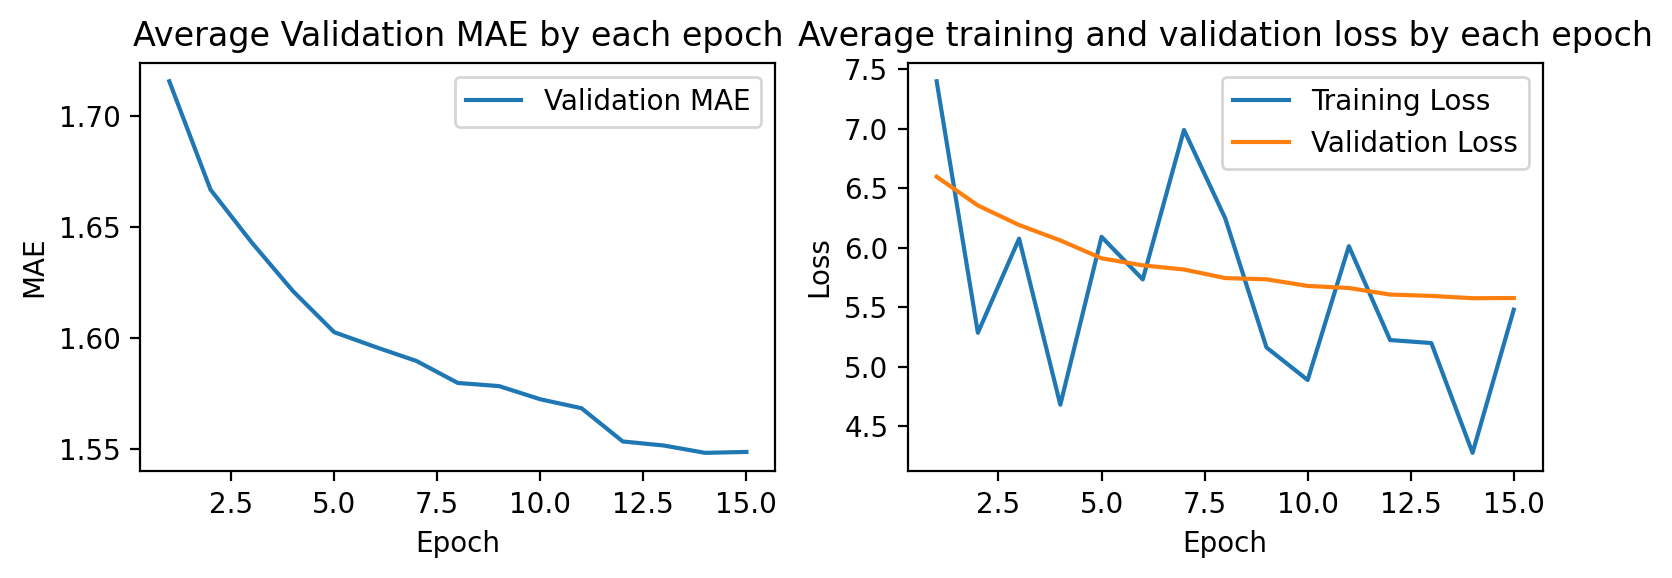

In [44]:
epochs = range(1, len(all_epoch_val_mae) + 1)

# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3)) # Adjust figsize as needed

# Plotting the Validation MAE on the first subplot (ax1)
ax1.plot(epochs, [np.mean(l) for l in all_epoch_val_mae], label='Validation MAE')

# Adding labels and title to the first subplot
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAE')
ax1.set_title("Average Validation MAE by each epoch")
ax1.legend()

# Plotting the Training and Validation Loss on the second subplot (ax2)
ax2.plot(epochs, [np.mean(l) for l in all_epoch_train_loss], label='Training Loss')
ax2.plot(epochs, [np.mean(l) for l in all_epoch_val_loss], label='Validation Loss')

# Adding labels and title to the second subplot
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title("Average training and validation loss by each epoch")
ax2.legend()

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

## Print one batch of attention weights

In [39]:
print( activations_P[mb2.attention1].shape )
print( activations_P[mb2.attention1][50] )

print( activations_L[mb1.attention1].shape )
print( activations_L[mb1.attention1][50] )

torch.Size([64, 100, 100])
tensor([[-0.1845, -0.1857,  0.1784,  ...,  0.1739, -0.1424,  0.1721],
        [-0.1845, -0.1857,  0.1784,  ...,  0.1739, -0.1424,  0.1721],
        [-0.1845, -0.1857,  0.1784,  ...,  0.1739, -0.1424,  0.1721],
        ...,
        [-0.1155, -0.1197,  0.1144,  ...,  0.1173, -0.0867,  0.1207],
        [-0.0830, -0.0882,  0.0823,  ...,  0.0907, -0.0589,  0.0972],
        [-0.0472, -0.0545,  0.0515,  ...,  0.0639, -0.0284,  0.0758]],
       device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([64, 100, 100])
tensor([[ 0.0296, -0.0760, -0.0254,  ...,  0.0119, -0.0702, -0.0067],
        [ 0.0296, -0.0760, -0.0254,  ...,  0.0119, -0.0702, -0.0067],
        [ 0.0296, -0.0760, -0.0254,  ...,  0.0119, -0.0702, -0.0067],
        ...,
        [ 0.0305, -0.0765, -0.0256,  ...,  0.0143, -0.0723, -0.0038],
        [ 0.0312, -0.0767, -0.0260,  ...,  0.0161, -0.0735, -0.0015],
        [ 0.0294, -0.0758, -0.0254,  ...,  0.0116, -0.0698, -0.0071]],
       device='cuda:0', gra

# Prediction on training set

In [40]:
%%time
# Clear Torch GPU cache
torch.cuda.empty_cache()
train_losses = [] # track loss
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over test data
test_mask = []
outcome = []
masks = []
predictions = []  # Store raw predictions
true_values = []  # Store true continuous values

# Empty list to store attention weights
all_attention_weights_P = []
all_attention_weights_L = []

train_on_gpu = True
use_mask = True

# Change criterion for regression (MSE loss)
criterion = nn.MSELoss()

train_word_pred = np.zeros((pad_embedding_matrix.shape[0], 2))
train_mask_counter = np.zeros((pad_embedding_matrix.shape[0], 2))

train_word_dist = [[] for x in range(pad_embedding_matrix.shape[0])]
train_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

# create an 2d empty numpy array to collect each batch save_out into one container
train_save_out = np.zeros((len(train_loader) * batch_size, pad_size))


if train_on_gpu:
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)

for batch_i, (inputs, labels) in enumerate(train_loader):
    if batch_i % 100 == 0:
        print(f"begin batch: {batch_i}")
    if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:, 0:pad_size], inputs[:, pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds, mask_1 = mb0(texts)
    mask_out, p1, p3, mean_mask = mb2(embeds, mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds, mask_1, mask_out, digits)
    #train_sent_out[batch_i*batch_size:(batch_i+1)*batch_size, :] = sent_out.detach().cpu().numpy()
    output, p2, save_out = mb3(sent_out, digits, mask_out, use_mask)

    mask_out = mask_out.detach()
    mask_out_np = mask_out.detach().to('cpu').numpy()
    norms = torch.norm(save_out, p=1, dim=1).pow(0.5).detach().cpu().numpy()  # normalize sentiment output by sqrt of sentence l1
    save_out_np = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()

    # stack each batch save_out into the train_save_out
    train_save_out[batch_i*batch_size:(batch_i+1)*batch_size, 0:pad_size] = save_out_np

    # Calculate mean mask (same as before)
    sums = 0
    word_c = 0
    for b_i in range(mask_out_np.shape[0]):
        length = digits[b_i, digits_dim - 1].to('cpu').numpy()
        word_c += length
        tmp = mask_out_np[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)
    mean_mask1 = sums / word_c
    masks.append(mean_mask1)

    # Word-level statistics (same as before)
    for id1, doc in enumerate(inputs_tmp[:, :100]):
        for id2, word in enumerate(doc):
            train_word_pred[word, 0] += save_out_np[id1, id2]
            train_word_pred[word, 1] += 1

            if mask_out_np[id1, id2] > 0.5:
                train_mask_counter[word, 0] += 1
            else:
                train_mask_counter[word, 1] += 1

            train_word_dist[word].append(save_out_np[id1, id2])
            train_mask_dist[word].append(mask_out_np[id1, id2])

    # calculate loss
    train_loss = criterion(output.squeeze(), labels.float())
    train_losses.append(train_loss.item())

    # Store raw predictions and true values
    predictions.extend(output.squeeze().detach().cpu().numpy())
    true_values.extend(labels.float().detach().cpu().numpy())

    # Store attention weights
    all_attention_weights_P.append(activations_P[mb2.attention1].cpu().detach().numpy())
    all_attention_weights_L.append(activations_L[mb1.attention1].cpu().detach().numpy())

# -- stats! -- ##
# avg test loss
print("Train loss (MSE): {:.4f}".format(np.mean(train_losses)))

# Calculate additional regression metrics
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print("Mean Absolute Error: {:.4f}".format(mae))
print("R-squared: {:.4f}".format(r2))
print("Mean prediction: {:.4f}".format(np.mean(predictions)))
print("Mean true value: {:.4f}".format(np.mean(true_values)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))

begin batch: 0
begin batch: 100
Train loss (MSE): 5.3782
Mean Absolute Error: 1.5720
R-squared: 0.7176
Mean prediction: 87.1804
Mean true value: 87.0507
Mean_mask: 0.7212
CPU times: user 4.79 s, sys: 540 ms, total: 5.33 s
Wall time: 5.3 s


## Diagnosis Plots for training

/tmp/ipython-input-41-4286889750.py:63: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_values, label='True Values', shade=True)
/tmp/ipython-input-41-4286889750.py:64: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions, label='Predictions', shade=True)


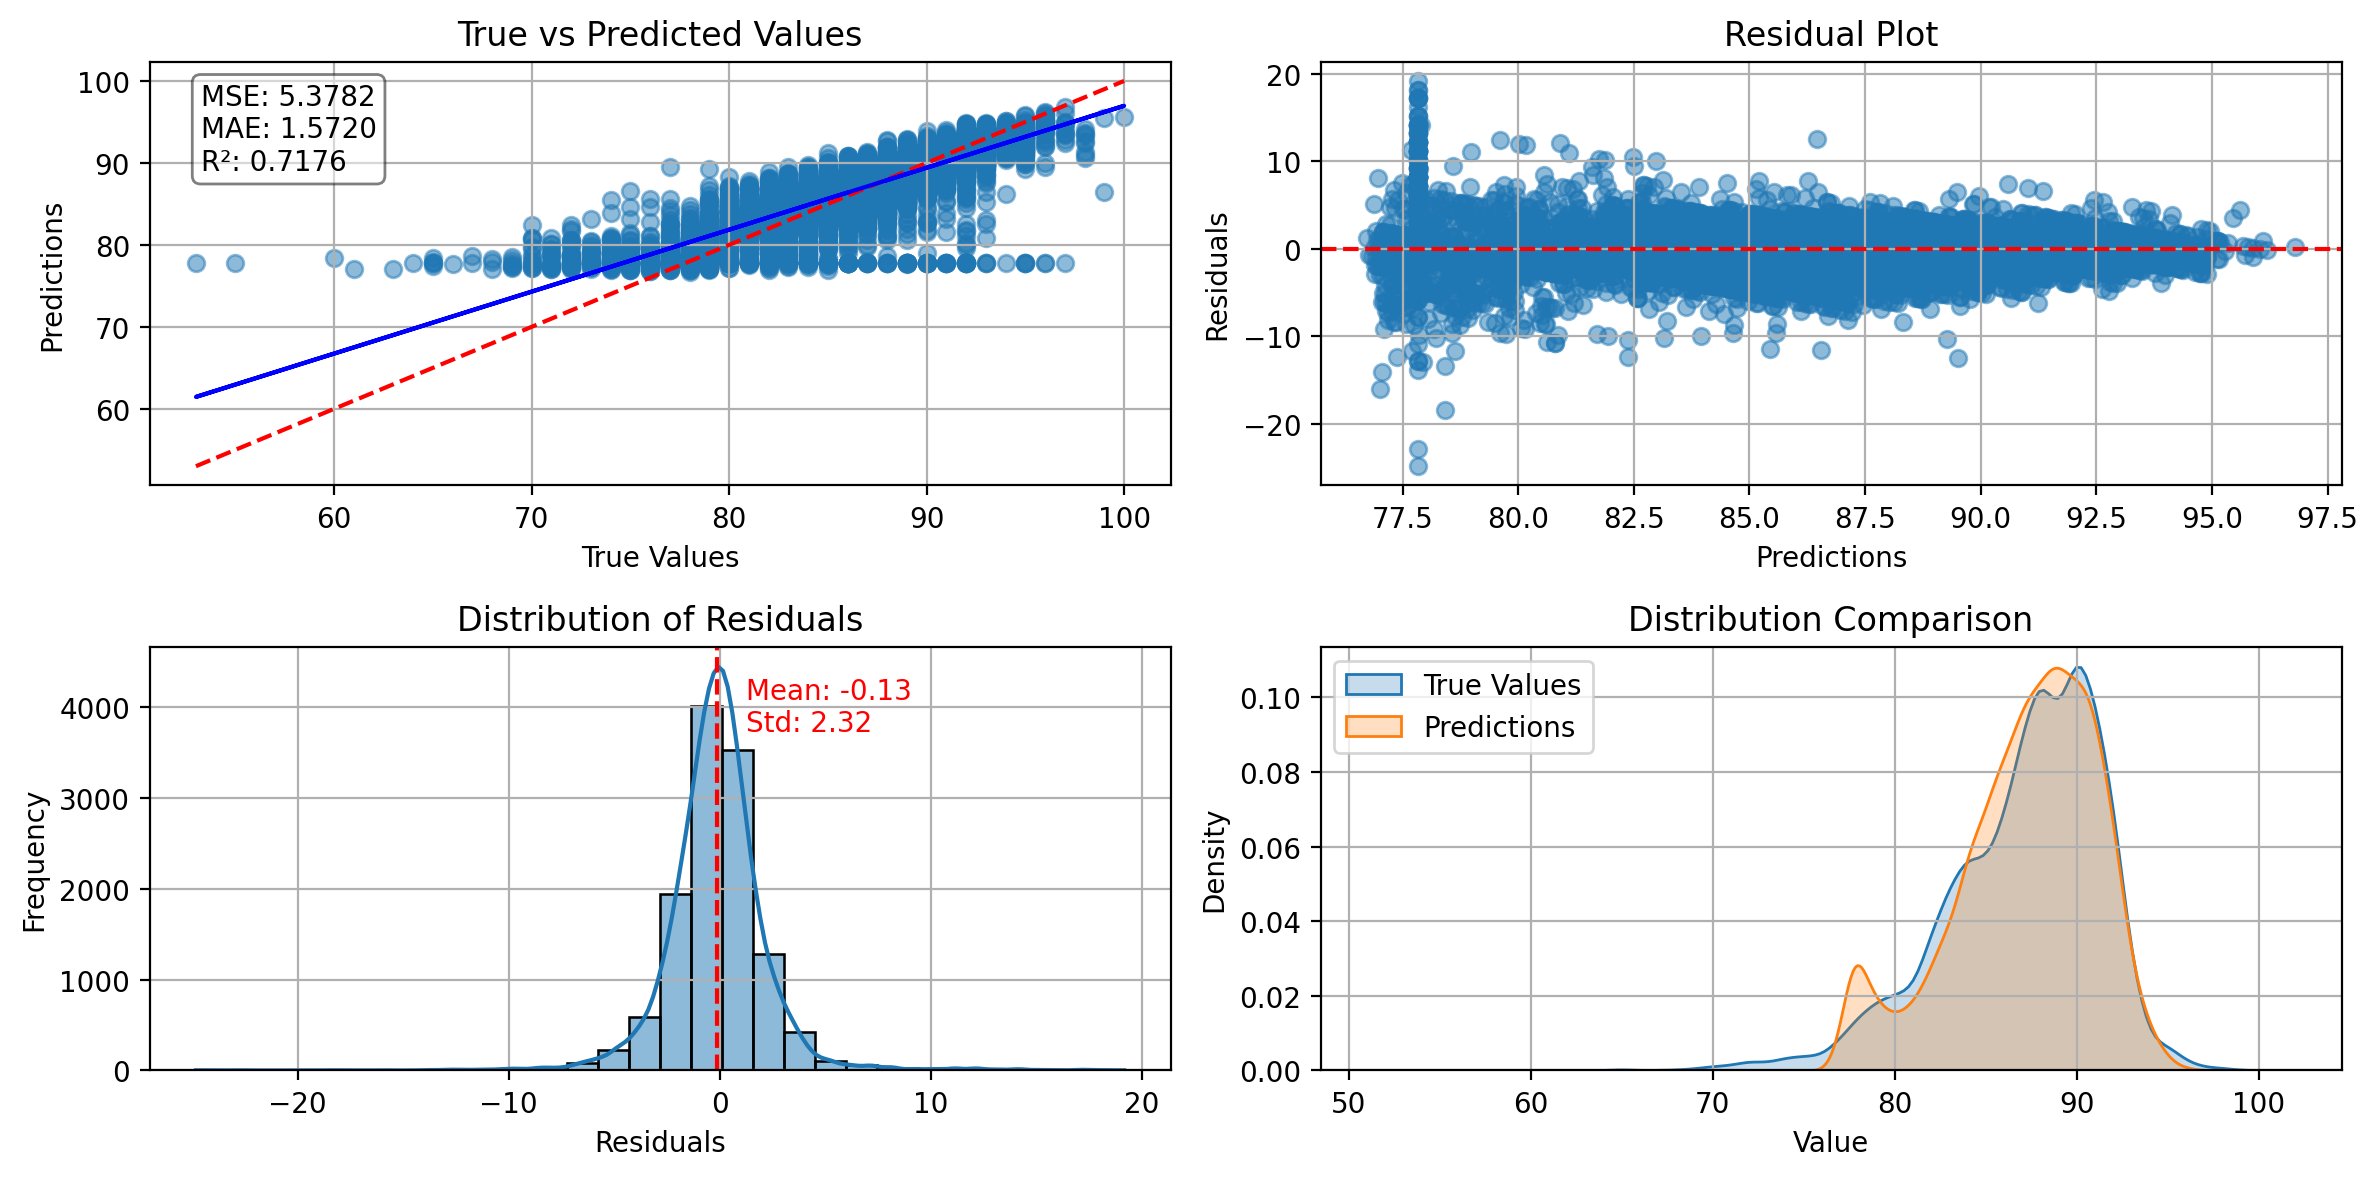

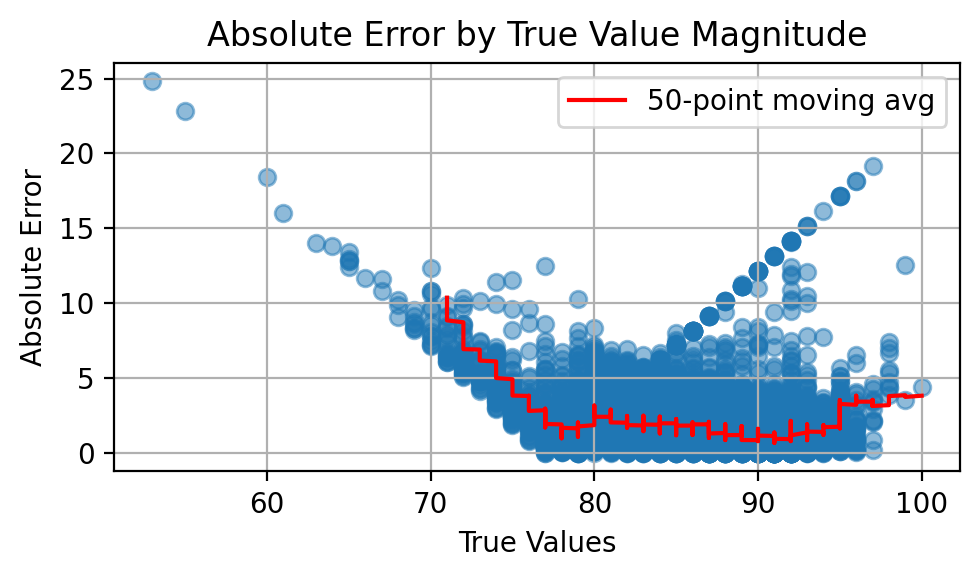

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert to numpy arrays if they aren't already
true_values = np.array(true_values)
predictions = np.array(predictions)

# Calculate residuals (difference between true and predicted)
residuals = true_values - predictions

# Create figure with subplots
plt.figure(figsize=(12, 6))

# 1. True vs Predicted scatter plot
plt.subplot(2, 2, 1)
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')  # Perfect prediction line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.grid(True)

# Calculate regression line
m, b = np.polyfit(true_values, predictions, 1)
plt.plot(true_values, m*true_values + b, color='blue')

# Add metrics to plot
metrics_text = f'MSE: {mean_squared_error(true_values, predictions):.4f}\n' \
               f'MAE: {mean_absolute_error(true_values, predictions):.4f}\n' \
               f'R²: {r2_score(true_values, predictions):.4f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# 2. Residual plot
plt.subplot(2, 2, 2)
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)

# 3. Distribution of residuals
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

# Add mean and std to residual distribution plot
resid_mean = np.mean(residuals)
resid_std = np.std(residuals)
plt.axvline(resid_mean, color='r', linestyle='--')
plt.text(resid_mean+0.6*resid_std, plt.ylim()[1]*0.8,
         f'Mean: {resid_mean:.2f}\nStd: {resid_std:.2f}',
         color='red')

# 4. Distribution of true vs predicted values
plt.subplot(2, 2, 4)
sns.kdeplot(true_values, label='True Values', shade=True)
sns.kdeplot(predictions, label='Predictions', shade=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional visualization: Error by magnitude
plt.figure(figsize=(5, 3))
absolute_errors = np.abs(residuals)
plt.scatter(true_values, absolute_errors, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Absolute Error')
plt.title('Absolute Error by True Value Magnitude')
plt.grid(True)

# Add moving average of errors
sorted_idx = np.argsort(true_values)
window_size = 50
moving_avg = np.convolve(absolute_errors[sorted_idx], np.ones(window_size)/window_size, mode='valid')
plt.plot(true_values[sorted_idx][window_size-1:], moving_avg, color='red', label=f'{window_size}-point moving avg')
plt.legend()

plt.tight_layout()
plt.show()

## Merge train prediction with ds

In [42]:
# Assuming train_index contains the original indices for the training set
# And train_loader is your DataLoader with drop_last=True

train_dataset = train_loader.dataset
batch_size = train_loader.batch_size
num_samples_in_loader = len(train_loader) * batch_size

# Calculate the average scores for each row across all columns in train_save_out
average_scores = np.mean(train_save_out, axis=1)
print("Shape of average scores:", average_scores.shape)

# Get the indices that are included in the DataLoader after dropping the last batch
included_train_indices = train_index[:num_samples_in_loader]

print("Original train indices:", train_index)
print("Indices included in the train DataLoader (after dropping last batch):", included_train_indices)

train_results_df = pd.DataFrame({
    'index': included_train_indices,
    'true_rating': true_values,       # your list/array of ground-truth ratings
    'predicted_rating': predictions,   # your list/array of model outputs
    'sentiment': average_scores   # your list/array of average scores
})

# Merge back with your full dataset (ds) on 'index'
merged_train_results = train_results_df.merge(ds, on='index', how='left')

print("Merged DataFrame:")
print(merged_train_results.shape)
# Inspect
merged_train_results.head()

Shape of average scores: (12416,)
Original train indices: [2155, 1057, 4014, 8677, 7879, 9187, 685, 81, 7911, 7125, 5425, 2408, 939, 3382, 10803, 1951, 6078, 10372, 13672, 12873, 6241, 4378, 11005, 12248, 12346, 579, 4772, 13669, 2990, 2966, 8884, 5516, 13413, 5134, 1758, 212, 11441, 12922, 13038, 107, 8923, 12845, 5122, 11670, 13684, 1620, 6706, 78, 11436, 5696, 7495, 12923, 5255, 6356, 4882, 10382, 6468, 10339, 1172, 782, 4392, 8174, 11367, 6877, 6056, 13272, 2032, 4454, 10259, 6532, 6817, 11786, 5272, 4700, 11118, 13064, 11762, 10147, 3657, 4310, 6857, 3599, 10257, 10049, 11181, 10221, 5792, 13680, 9302, 13008, 2120, 8279, 12342, 900, 1981, 2178, 5152, 10271, 11530, 8484, 4961, 3240, 7936, 7105, 3597, 1395, 10980, 1110, 13123, 2316, 11361, 11077, 4533, 63, 7590, 1952, 1017, 6739, 8543, 13389, 10109, 9342, 6450, 7699, 4109, 2117, 10492, 2838, 6347, 9222, 7792, 3982, 8299, 12712, 1174, 2296, 12975, 7209, 5873, 587, 10214, 9055, 11107, 12769, 12473, 11487, 13067, 3062, 11368, 10163, 76

,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year
0,2155,86.0,85.915527,0.848871,86,"Dry and balanced, this offers subtle apricot, ...",NV (reviewed 2011)
1,1057,77.0,79.980240,0.298385,77,"Varietal but not aggressively so, nicely balan...",NV (reviewed 1987)
2,4014,88.0,88.889862,1.172597,88,"Fresh, this rosé is reminiscent of red currant...",NV (reviewed 2006)
3,8677,77.0,77.606094,0.094205,77,Earthy grapefruit flavors turn a bit a sour on...,NV (reviewed 1992)
4,7879,89.0,87.877487,1.056778,89,"Crisp and steely, with appealing almond brioch...",NV (reviewed 2013)


## Save some results

In [ ]:
'''
# Access the fc1 layer
fc1_layer = mb2.fc1

# Extract weights and bias
weights = fc1_layer.weight
bias = fc1_layer.bias

# Print the shapes to verify
print("Weights shape:", weights.shape)
print("Bias shape:", bias.shape)

# Save weights and bias
torch.save(weights, './attention/mb2.fc1.weights_100.pt')
torch.save(bias, './attention/mb2.fc1.bias_100.pt')
'''

'\n# Access the fc1 layer\nfc1_layer = mb2.fc1\n\n# Extract weights and bias\nweights = fc1_layer.weight\nbias = fc1_layer.bias\n\n# Print the shapes to verify\nprint("Weights shape:", weights.shape)\nprint("Bias shape:", bias.shape)\n\n# Save weights and bias\ntorch.save(weights, \'./attention/mb2.fc1.weights_100.pt\')\ntorch.save(bias, \'./attention/mb2.fc1.bias_100.pt\')\n'

In [ ]:
'''
# Access the fc2 layer
fc2_layer = mb1.fc2

# Extract weights and bias
weights = fc2_layer.weight
bias = fc2_layer.bias

# Print the shapes to verify
print("Weights shape:", weights.shape)
print("Bias shape:", bias.shape)

# Save weights and bias
torch.save(weights, './attention/mb1.fc2.weights_100.pt')
torch.save(bias, './attention/mb1.fc2.bias_100.pt')
'''

'\n# Access the fc2 layer\nfc2_layer = mb1.fc2\n\n# Extract weights and bias\nweights = fc2_layer.weight\nbias = fc2_layer.bias\n\n# Print the shapes to verify\nprint("Weights shape:", weights.shape)\nprint("Bias shape:", bias.shape)\n\n# Save weights and bias\ntorch.save(weights, \'./attention/mb1.fc2.weights_100.pt\')\ntorch.save(bias, \'./attention/mb1.fc2.bias_100.pt\')\n'

In [ ]:
'''
# Save class instances for mb1, mb2, mb3, mb0
import pickle
with open('./attention/mb1.pkl', 'wb') as f:
    pickle.dump(mb1, f)

with open('./attention/mb2.pkl', 'wb') as f:
    pickle.dump(mb2, f)

with open('./attention/mb3.pkl', 'wb') as f:
    pickle.dump(mb3, f)

with open('./attention/mb0.pkl', 'wb') as f:
    pickle.dump(mb0, f)
'''

"\n# Save class instances for mb1, mb2, mb3, mb0\nimport pickle\nwith open('./attention/mb1.pkl', 'wb') as f:\n    pickle.dump(mb1, f)\n\nwith open('./attention/mb2.pkl', 'wb') as f:\n    pickle.dump(mb2, f)\n\nwith open('./attention/mb3.pkl', 'wb') as f:\n    pickle.dump(mb3, f)\n\nwith open('./attention/mb0.pkl', 'wb') as f:\n    pickle.dump(mb0, f)\n"

In [ ]:
'''
# Save this all_attention_weights_P and _L into local disk
# Save after training
import pickle

with open('./attention/attention_weights_P_100.pkl', 'wb') as f:
    pickle.dump(all_attention_weights_P, f)

with open('./attention/attention_weights_L_100.pkl', 'wb') as f:
    pickle.dump(all_attention_weights_L, f)

# Save the true_labels
with open('./attention/true_labels_100.pkl', 'wb') as f:
    pickle.dump(true_labels, f)
'''

"\n# Save this all_attention_weights_P and _L into local disk\n# Save after training\nimport pickle\n\nwith open('./attention/attention_weights_P_100.pkl', 'wb') as f:\n    pickle.dump(all_attention_weights_P, f)\n\nwith open('./attention/attention_weights_L_100.pkl', 'wb') as f:\n    pickle.dump(all_attention_weights_L, f)\n\n# Save the true_labels\nwith open('./attention/true_labels_100.pkl', 'wb') as f:\n    pickle.dump(true_labels, f)\n"

## Extract the sentiment scores for each word in the training set

In [ ]:
'''
def pad_or_truncate(words, max_length, pad_char='0'):
    """
    Pad or truncate a list of words to a specific length.

    Parameters:
    - words (list): The list of words to pad or truncate.
    - max_length (int): The desired length of the list after padding or truncating.
    - pad_char (str): The character used to pad the list.

    Returns:
    - list: The padded or truncated list.
    """
    if len(words) < max_length:
        # Pad the list
        padded = [pad_char] * (max_length - len(words)) + words
        return padded
    else:
        # Truncate the list
        truncated = words[:max_length]
        return truncated
'''

'\ndef pad_or_truncate(words, max_length, pad_char=\'0\'):\n    """\n    Pad or truncate a list of words to a specific length.\n\n    Parameters:\n    - words (list): The list of words to pad or truncate.\n    - max_length (int): The desired length of the list after padding or truncating.\n    - pad_char (str): The character used to pad the list.\n\n    Returns:\n    - list: The padded or truncated list.\n    """\n    if len(words) < max_length:\n        # Pad the list\n        padded = [pad_char] * (max_length - len(words)) + words\n        return padded\n    else:\n        # Truncate the list\n        truncated = words[:max_length]\n        return truncated\n'

In [ ]:
'''
# convert the below list into a pandas data frame
new_train = [new_wine_sents[i] for i in train_index]
new_train_pad = [pad_or_truncate(each, 100) for each in new_train]
new_train_pad_df = pd.DataFrame(new_train_pad)
print(new_train_pad_df.shape)
new_train_pad_df.to_csv('/content/drive/MyDrive/AMIC project/train score/train_word.csv')
'''

"\n# convert the below list into a pandas data frame\nnew_train = [new_wine_sents[i] for i in train_index]\nnew_train_pad = [pad_or_truncate(each, 100) for each in new_train]\nnew_train_pad_df = pd.DataFrame(new_train_pad)\nprint(new_train_pad_df.shape)\nnew_train_pad_df.to_csv('/content/drive/MyDrive/AMIC project/train score/train_word.csv')\n"

In [ ]:
'''
df_train_save_out = pd.DataFrame(train_save_out)
print(df_train_save_out.shape)
#df_save_out
# save
df_train_save_out.to_csv('/content/drive/MyDrive/AMIC project/train score/train_score.csv')
'''

"\ndf_train_save_out = pd.DataFrame(train_save_out)\nprint(df_train_save_out.shape)\n#df_save_out\n# save\ndf_train_save_out.to_csv('/content/drive/MyDrive/AMIC project/train score/train_score.csv')\n"


# Prediction on validation set

begin batch 0
begin batch 20
begin batch 40
begin batch 60
begin batch 80
begin batch 100
begin batch 120
Validation loss (MSE): 2.2976
Mean Absolute Error: 1.1610
R-squared: 0.7816
Mean prediction: 88.1215
Mean true value: 88.1069
Mean_mask: 0.4779
Size of valid_save_out: (7744, 100)


<timed exec>:169: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

<timed exec>:170: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



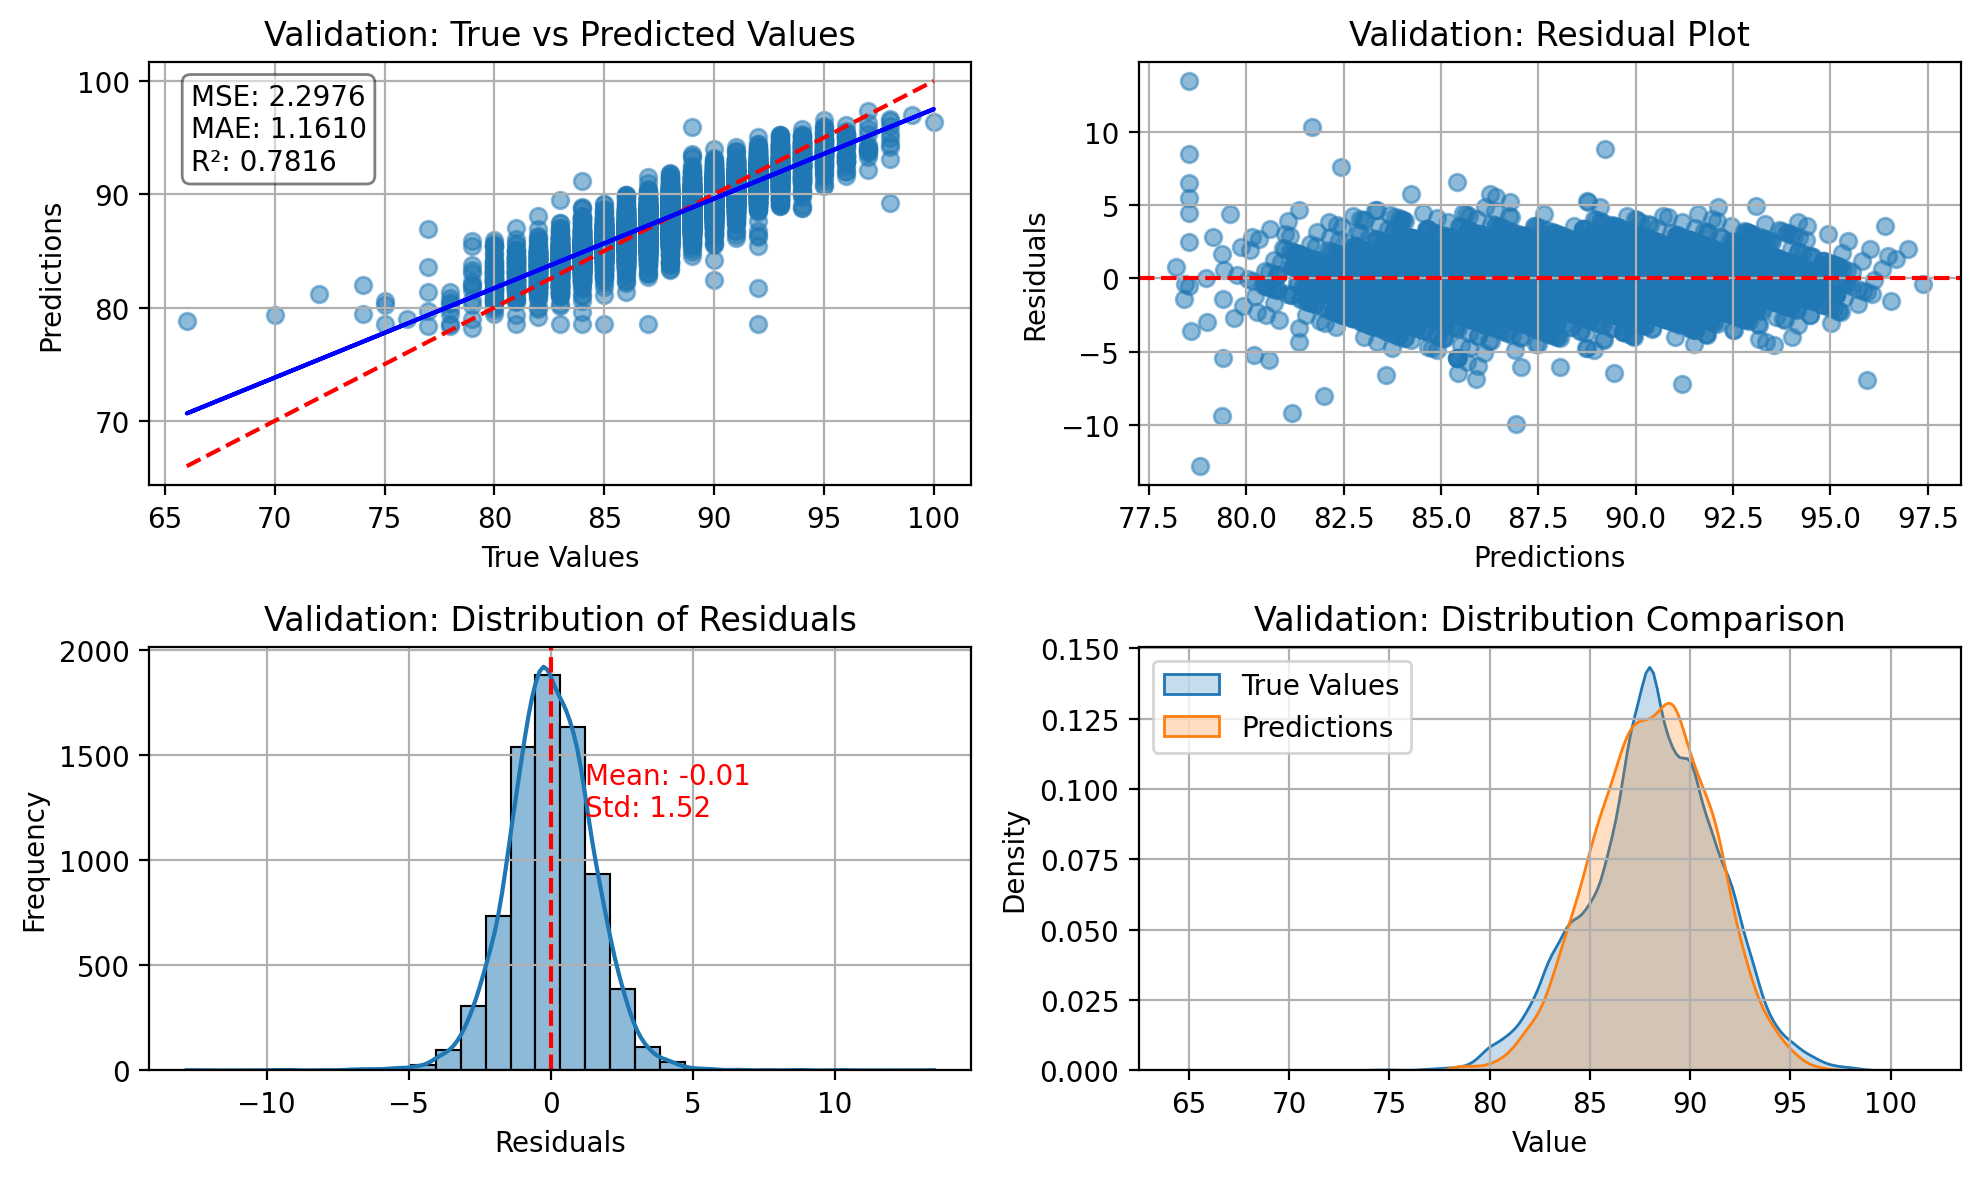

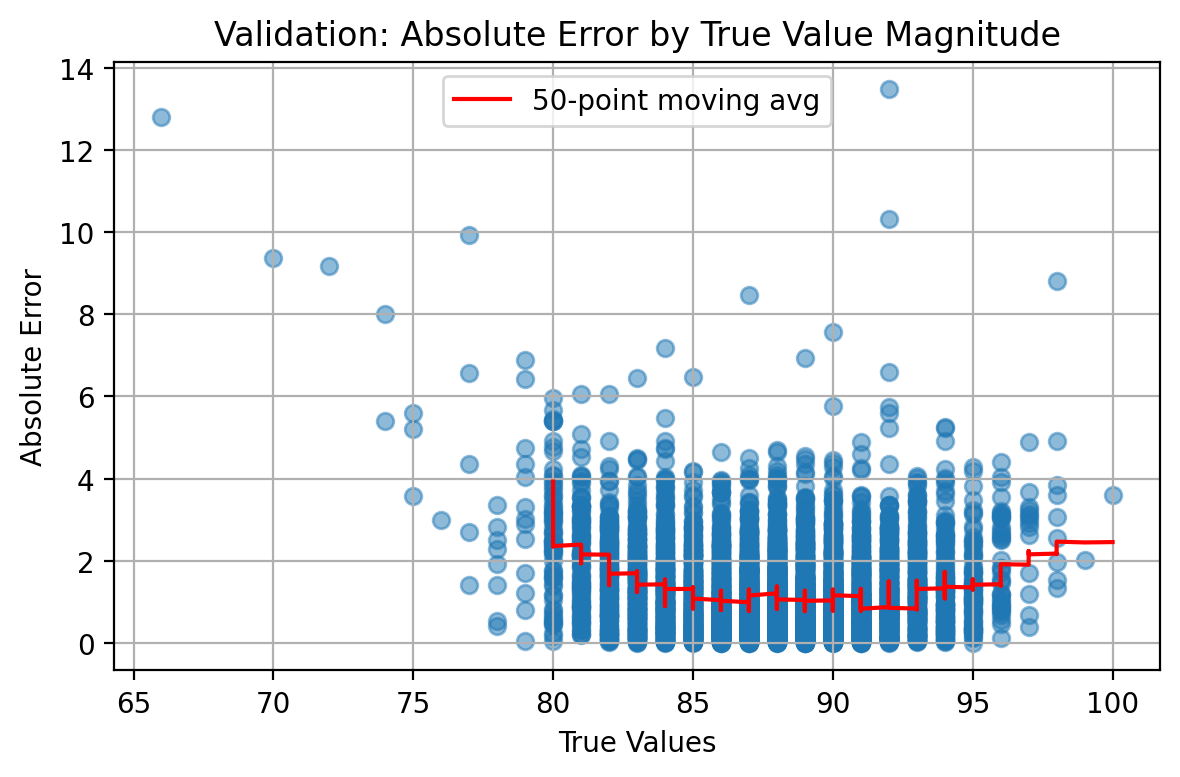

CPU times: user 7.87 s, sys: 71 ms, total: 7.94 s
Wall time: 4.37 s


In [ ]:
%%time
validation_losses = [] # track loss
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over val data
masks = []
predictions = []  # Store raw predictions
true_values = []  # Store true continuous values

train_on_gpu = True
use_mask = True

# Change criterion for regression (MSE loss)
criterion = nn.MSELoss()

val_word_pred = np.zeros((pad_embedding_matrix.shape[0], 2))
val_mask_counter = np.zeros((pad_embedding_matrix.shape[0], 2))

val_word_dist = [[] for x in range(pad_embedding_matrix.shape[0])]
val_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

# create an 2d empty numpy array to collect each batch save_out into one container
valid_save_out = np.zeros((len(valid_loader) * batch_size, pad_size))

if train_on_gpu:
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)

for batch_i, (inputs, labels) in enumerate(valid_loader):
    if batch_i % 20 == 0:
        print(f"begin batch {batch_i}")
    if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:, 0:pad_size], inputs[:, pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds, mask_1 = mb0(texts)
    mask_out, p1, p3, mean_mask = mb2(embeds, mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds, mask_1, mask_out, digits)
    output, p2, save_out = mb3(sent_out, digits, mask_out, use_mask)

    mask_out = mask_out.detach()
    mask_out_np = mask_out.detach().to('cpu').numpy()
    save_out_np = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()

    # stack each batch save_out into the valid_save_out
    valid_save_out[batch_i*batch_size:(batch_i+1)*batch_size, 0:pad_size] = save_out_np

    # Calculate mean mask
    sums = 0
    word_c = 0
    for b_i in range(mask_out_np.shape[0]):
        length = digits[b_i, digits_dim - 1].to('cpu').numpy()
        word_c += length
        tmp = mask_out_np[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)
    mean_mask1 = sums / word_c
    masks.append(mean_mask1)

    # Word-level statistics
    for id1, doc in enumerate(inputs_tmp[:, :100]):
        for id2, word in enumerate(doc):
            val_word_pred[word, 0] += save_out_np[id1, id2]
            val_word_pred[word, 1] += 1

            if mask_out_np[id1, id2] > 0.5:
                val_mask_counter[word, 0] += 1
            else:
                val_mask_counter[word, 1] += 1

            val_word_dist[word].append(save_out_np[id1, id2])
            val_mask_dist[word].append(mask_out_np[id1, id2])

    # calculate loss
    validation_loss = criterion(output.squeeze(), labels.float())
    validation_losses.append(validation_loss.item())

    # Store raw predictions and true values
    predictions.extend(output.squeeze().detach().cpu().numpy())
    true_values.extend(labels.float().detach().cpu().numpy())

# -- stats! -- ##
# avg test loss
print("Validation loss (MSE): {:.4f}".format(np.mean(validation_losses)))

# Calculate additional regression metrics
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print("Mean Absolute Error: {:.4f}".format(mae))
print("R-squared: {:.4f}".format(r2))
print("Mean prediction: {:.4f}".format(np.mean(predictions)))
print("Mean true value: {:.4f}".format(np.mean(true_values)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
print("Size of valid_save_out:", valid_save_out.shape)

# Visualization plots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to numpy arrays if they aren't already
true_values = np.array(true_values)
predictions = np.array(predictions)

# Calculate residuals (difference between true and predicted)
residuals = true_values - predictions

# Create figure with subplots
plt.figure(figsize=(10, 6))

# 1. True vs Predicted scatter plot
plt.subplot(2, 2, 1)
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')  # Perfect prediction line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Validation: True vs Predicted Values')
plt.grid(True)

# Calculate regression line
m, b = np.polyfit(true_values, predictions, 1)
plt.plot(true_values, m*true_values + b, color='blue')

# Add metrics to plot
metrics_text = f'MSE: {np.mean(validation_losses):.4f}\n' \
               f'MAE: {mae:.4f}\n' \
               f'R²: {r2:.4f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# 2. Residual plot
plt.subplot(2, 2, 2)
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Validation: Residual Plot')
plt.grid(True)

# 3. Distribution of residuals
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Validation: Distribution of Residuals')
plt.grid(True)

# Add mean and std to residual distribution plot
resid_mean = np.mean(residuals)
resid_std = np.std(residuals)
plt.axvline(resid_mean, color='r', linestyle='--')
plt.text(resid_mean+0.8*resid_std, plt.ylim()[1]*0.6,
         f'Mean: {resid_mean:.2f}\nStd: {resid_std:.2f}',
         color='red')

# 4. Distribution of true vs predicted values
plt.subplot(2, 2, 4)
sns.kdeplot(true_values, label='True Values', shade=True)
sns.kdeplot(predictions, label='Predictions', shade=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Validation: Distribution Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional visualization: Error by magnitude
plt.figure(figsize=(6, 4))
absolute_errors = np.abs(residuals)
plt.scatter(true_values, absolute_errors, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Absolute Error')
plt.title('Validation: Absolute Error by True Value Magnitude')
plt.grid(True)

# Add moving average of errors
sorted_idx = np.argsort(true_values)
window_size = 50
moving_avg = np.convolve(absolute_errors[sorted_idx], np.ones(window_size)/window_size, mode='valid')
plt.plot(true_values[sorted_idx][window_size-1:], moving_avg, color='red', label=f'{window_size}-point moving avg')
plt.legend()

plt.tight_layout()
plt.show()

## Merge validation predictions with ds

In [ ]:
# Assuming val_index contains the original indices for the validation set
# And val_loader is your DataLoader with drop_last=True

val_dataset = valid_loader.dataset
batch_size = valid_loader.batch_size
num_samples_in_loader = len(valid_loader) * batch_size

# Get the indices that are included in the DataLoader after dropping the last batch
included_val_indices = valid_index[:num_samples_in_loader]

print("Original validation indices:", valid_index)
print("Indices included in the validation DataLoader (after dropping last batch):", included_val_indices)

val_results_df = pd.DataFrame({
    'index': included_val_indices,
    'true_rating': true_values,       # your list/array of true values
    'predicted_rating': predictions,   # your list/array of model outputs
    'sentiment': np.mean(valid_save_out, axis=1)   # your list/array of average scores
})

#val_results_df

# Join with the original ds DataFrame
# Use 'left' join to keep all rows from test_results_df_indexed on index column
merged_valid_results = val_results_df.merge(ds, on='index', how='left')

# Display the first few rows of the merged DataFrame
merged_valid_results

Original validation indices: [145050, 33020, 110992, 108577, 46217, 45051, 88563, 95231, 22153, 85709, 111495, 129379, 67029, 121865, 15792, 111805, 96952, 42799, 89615, 143390, 94367, 145208, 94828, 143954, 49209, 55229, 86404, 16683, 106996, 34559, 106452, 106778, 100064, 44397, 120324, 112705, 19116, 105202, 39079, 56627, 45382, 34686, 82550, 6654, 107382, 49034, 107796, 2170, 6665, 155284, 22590, 65254, 53973, 62444, 56836, 135951, 57989, 16975, 48563, 77451, 102407, 52027, 144070, 108847, 32159, 59441, 30809, 48189, 131116, 64977, 132507, 59245, 64275, 147876, 112367, 58751, 114776, 53096, 31022, 154562, 139056, 142037, 50602, 23680, 121080, 43099, 89809, 88790, 81786, 14044, 101820, 17377, 155440, 33733, 99324, 3016, 6547, 95925, 10873, 85229, 142140, 154616, 28194, 29901, 99766, 9433, 99248, 10569, 114961, 151731, 10286, 115996, 96354, 123398, 63583, 57476, 110274, 150363, 43681, 57912, 23533, 128121, 54348, 65724, 114461, 71716, 21652, 115433, 78350, 51974, 75390, 55742, 140676

,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year
0,145050,93.0,91.539131,1.516222,93,"Features a racy core of red currant, damson pl...",2012
1,33020,88.0,87.084808,0.970447,88,"A friendly, polished, easygoing style, with ac...",2013
2,110992,93.0,92.709961,1.695094,93,Botrytis adds concentration and exotic notes t...,2010
3,108577,94.0,95.147903,2.161774,94,This sweetie features a light and airy texture...,2013
4,46217,88.0,86.855019,0.946047,88,"Fresh and fruity, showing hints of flowers and...",2007
...,...,...,...,...,...,...,...
7739,68901,95.0,93.894379,1.901782,95,"Unctuously sweet, silky and expressive, this b...",2015
7740,79230,89.0,88.038803,1.074788,89,"Soft, ripe and supple, a smooth mouthful of pr...",2012
7741,139411,88.0,87.640686,1.030619,88,"Fairly supple, with ripe cherry, lemon and gra...",NV (reviewed 1998)
7742,144407,89.0,87.747849,1.042416,89,"Cherry, mountain herb, licorice and black pepp...",2006


# Prediction on the test set

V_0_* :mask applied before sentiment attention
V_1_*: mask applied after sentiemnt attention
V_2_*: no attention for masking block

without premasking in sentiemnt block

v_1_0
Test loss: 0.2541
Mean_mask: 0.2575
Test accuracy: 0.8863

v_1_1

Test loss: 0.2541
Mean_mask: 0.2575
Test accuracy: 0.8863

oss_p = loss + torch.mean(p1*0.001).squeeze()+ torch.mean(p3*0.002)  +(torch.mean(p2*0.00015)).squeeze()

V0
Test loss: 0.2540
Mean_mask: 0.2522
Test accuracy: 0.8870

v1
Test loss: 0.2541
Mean_mask: 0.2461
Test accuracy: 0.8867

V2

Test loss: 0.2592
Mean_mask: 0.0973
Test accuracy: 0.8853
torch.mean(p1*0.01).squeeze()+ torch.mean(p3*0.03).squeeze() + (torch.mean(p4*0.00015)).squeeze() +(torch.mean(p2*0.00015)).squeeze()

V3

Test loss: 0.2592
Mean_mask: 0.0973
Test accuracy: 0.8853
 torch.mean(p1*0.0015).squeeze()+ torch.mean(p3*0.03).squeeze() + (torch.mean(p4*0.00015)).squeeze() +(torch.mean(p2*0.00015)).squeeze()

v4
Test loss: 0.3071
Mean_mask: 0.2602
Test accuracy: 0.8874
loss_p = loss + torch.mean(p1*0.01).squeeze()+ torch.mean(p3*0.02)  +(torch.mean(p2*0.0015)).squeeze() + (torch.mean(p4*0.001)).squeeze() +(torch.mean(p2*0.001)).squeeze()


begin batch 0
begin batch 20
begin batch 40
begin batch 60
begin batch 80
begin batch 100
begin batch 120
Test loss (MSE): 2.3009
Mean Squared Error: 2.3009
Mean Absolute Error: 1.1544
R-squared: 0.7790
Mean prediction: 88.1115
Mean true value: 88.1117
Mean_mask: 0.4764
Size of test_save_out: (7744, 100)


<timed exec>:174: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

<timed exec>:175: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



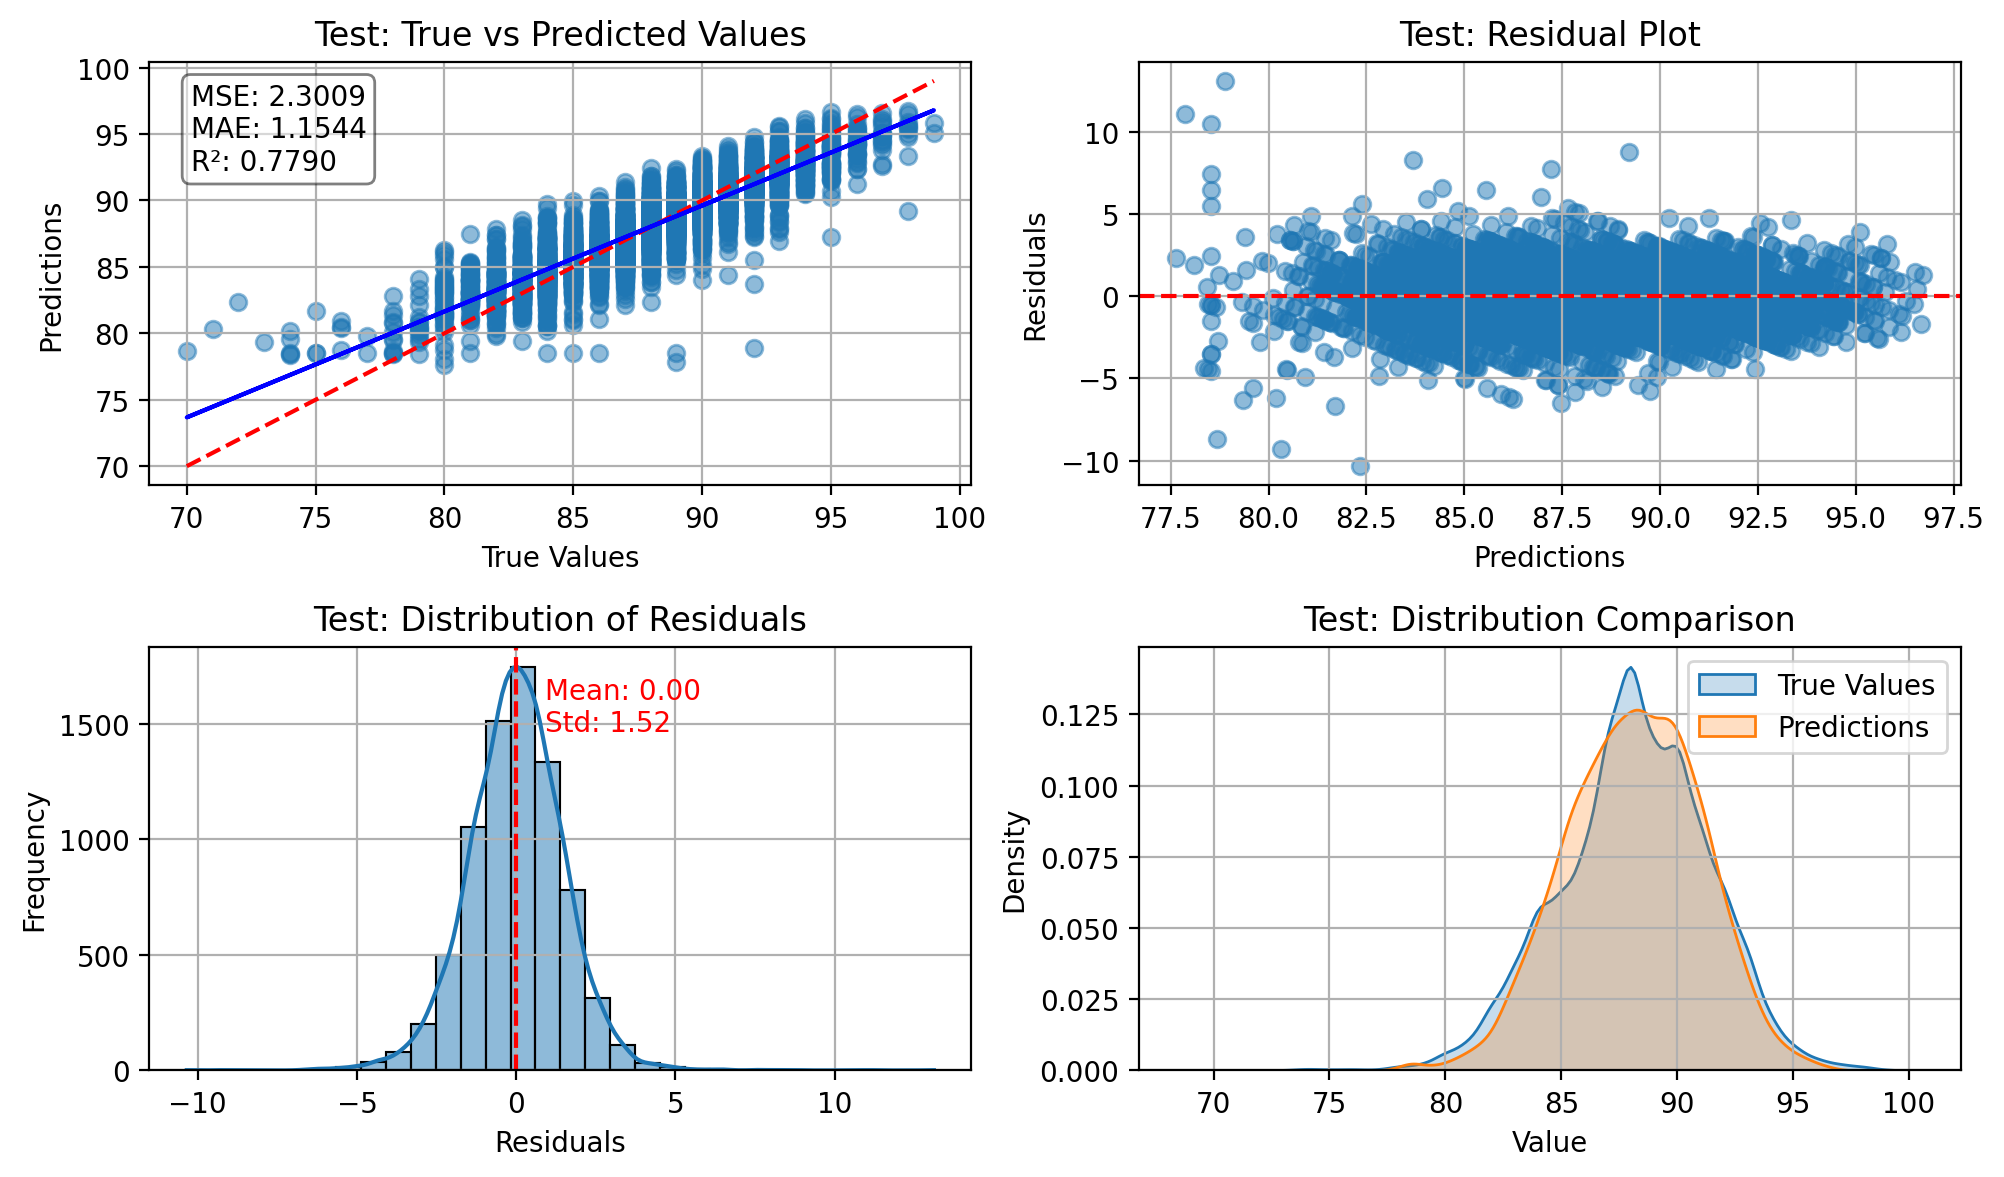

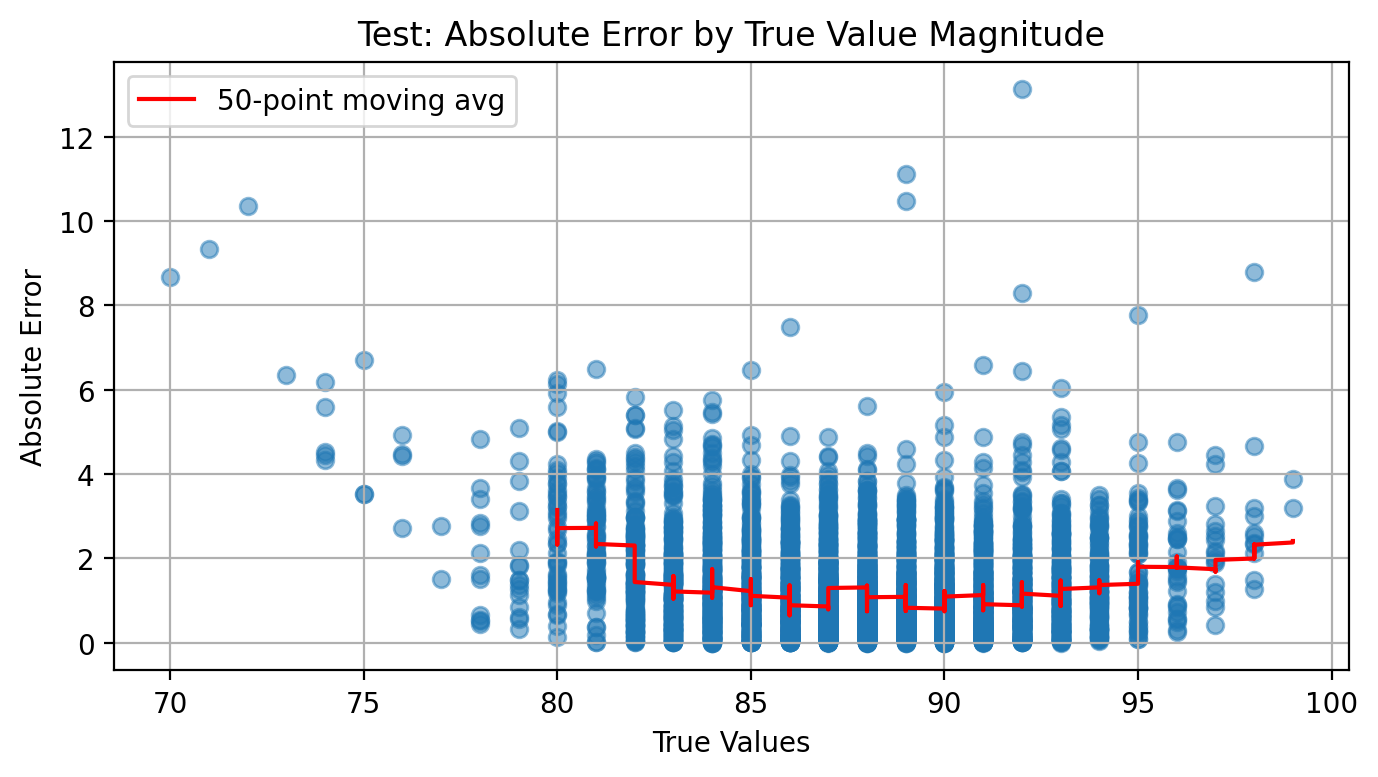

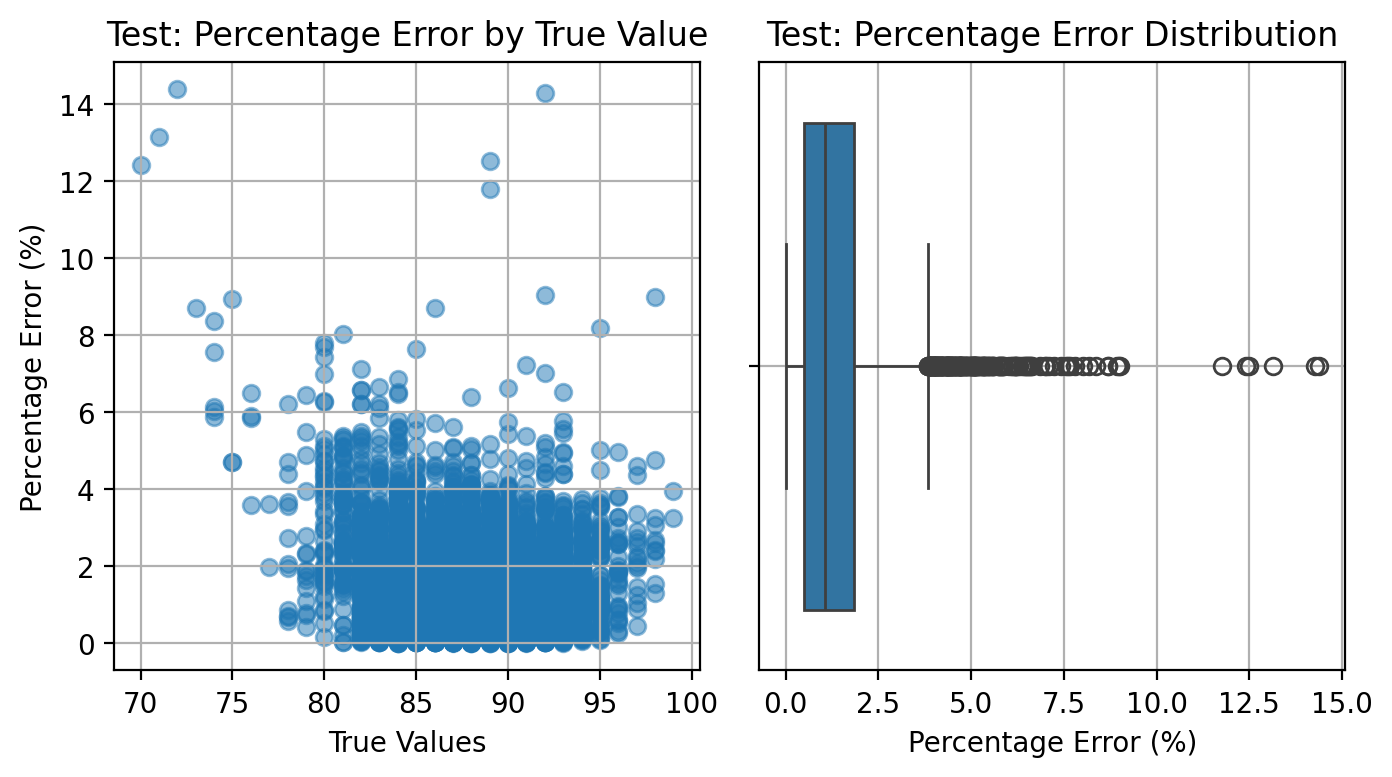

CPU times: user 10.4 s, sys: 78 ms, total: 10.5 s
Wall time: 6.83 s


In [ ]:
%%time
test_losses = [] # track loss
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over test data
masks = []
predictions = []  # Store raw predictions
true_values = []  # Store true continuous values

train_on_gpu = True
use_mask = True

# Change criterion for regression (MSE loss)
criterion = nn.MSELoss()

test_word_pred = np.zeros((pad_embedding_matrix.shape[0], 2))
test_value_pred = np.zeros((pad_embedding_matrix.shape[0], 2))
test_mask_counter = np.zeros((pad_embedding_matrix.shape[0], 2))

test_word_dist = [[] for x in range(pad_embedding_matrix.shape[0])]
test_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

# create an 2d empty numpy array to collect each batch save_out into one container
test_save_out = np.zeros((len(test_loader) * batch_size, pad_size))

if train_on_gpu:
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)

for batch_i, (inputs, labels) in enumerate(test_loader):
    if batch_i % 20 == 0:
        print(f"begin batch {batch_i}")
    if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:, 0:pad_size], inputs[:, pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds, mask_1 = mb0(texts)
    mask_out, p1, p3, mean_mask = mb2(embeds, mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds, mask_1, mask_out, digits)
    output, p2, save_out = mb3(sent_out, digits, mask_out, use_mask)

    mask_out = mask_out.detach()
    values_out = mask_out.detach().to('cpu').numpy()
    mask_out_np = mask_out.detach().to('cpu').numpy()
    save_out_np = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()

    # stack each batch save_out into the test_save_out
    test_save_out[batch_i*batch_size:(batch_i+1)*batch_size, 0:pad_size] = save_out_np

    # Calculate mean mask
    sums = 0
    word_c = 0
    for b_i in range(mask_out_np.shape[0]):
        length = digits[b_i, digits_dim - 1].to('cpu').numpy()
        word_c += length
        tmp = mask_out_np[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)
    mean_mask1 = sums / word_c
    masks.append(mean_mask1)

    # Word-level statistics
    for id1, doc in enumerate(inputs_tmp[:, :100]):
        for id2, word in enumerate(doc):
            test_word_pred[word, 0] += save_out_np[id1, id2]
            test_word_pred[word, 1] += 1

            test_value_pred[word, 0] += values_out[id1, id2]
            test_value_pred[word, 1] += 1

            if mask_out_np[id1, id2] > 0.5:
                test_mask_counter[word, 0] += 1
            else:
                test_mask_counter[word, 1] += 1

            test_word_dist[word].append(save_out_np[id1, id2])
            test_mask_dist[word].append(mask_out_np[id1, id2])

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # Store raw predictions and true values
    predictions.extend(output.squeeze().detach().cpu().numpy())
    true_values.extend(labels.float().detach().cpu().numpy())

# -- stats! -- ##
# avg test loss
print("Test loss (MSE): {:.4f}".format(np.mean(test_losses)))

# Calculate additional regression metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

print("Mean Squared Error: {:.4f}".format(mse))
print("Mean Absolute Error: {:.4f}".format(mae))
print("R-squared: {:.4f}".format(r2))
print("Mean prediction: {:.4f}".format(np.mean(predictions)))
print("Mean true value: {:.4f}".format(np.mean(true_values)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
print("Size of test_save_out:", test_save_out.shape)

# Visualization plots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to numpy arrays
true_values = np.array(true_values)
predictions = np.array(predictions)

# Calculate residuals
residuals = true_values - predictions

# Create figure with subplots
plt.figure(figsize=(10, 6))

# 1. True vs Predicted scatter plot
plt.subplot(2, 2, 1)
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')  # Perfect prediction line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test: True vs Predicted Values')
plt.grid(True)

# Calculate regression line
m, b = np.polyfit(true_values, predictions, 1)
plt.plot(true_values, m*true_values + b, color='blue')

# Add metrics to plot
metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# 2. Residual plot
plt.subplot(2, 2, 2)
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Test: Residual Plot')
plt.grid(True)

# 3. Distribution of residuals
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Test: Distribution of Residuals')
plt.grid(True)

# Add mean and std to residual distribution plot
resid_mean = np.mean(residuals)
resid_std = np.std(residuals)
plt.axvline(resid_mean, color='r', linestyle='--')
plt.text(resid_mean+0.6*resid_std, plt.ylim()[1]*0.8,
         f'Mean: {resid_mean:.2f}\nStd: {resid_std:.2f}',
         color='red')

# 4. Distribution of true vs predicted values
plt.subplot(2, 2, 4)
sns.kdeplot(true_values, label='True Values', shade=True)
sns.kdeplot(predictions, label='Predictions', shade=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Test: Distribution Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional visualization: Error by magnitude
plt.figure(figsize=(7, 4))
absolute_errors = np.abs(residuals)
plt.scatter(true_values, absolute_errors, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Absolute Error')
plt.title('Test: Absolute Error by True Value Magnitude')
plt.grid(True)

# Add moving average of errors
sorted_idx = np.argsort(true_values)
window_size = 50
moving_avg = np.convolve(absolute_errors[sorted_idx], np.ones(window_size)/window_size, mode='valid')
plt.plot(true_values[sorted_idx][window_size-1:], moving_avg, color='red', label=f'{window_size}-point moving avg')
plt.legend()

plt.tight_layout()
plt.show()

# Additional: Prediction Error Analysis
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
percent_error = 100 * np.abs(residuals) / (np.abs(true_values) + 1e-8)  # Avoid division by zero
plt.scatter(true_values, percent_error, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Percentage Error (%)')
plt.title('Test: Percentage Error by True Value')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=percent_error)
plt.xlabel('Percentage Error (%)')
plt.title('Test: Percentage Error Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

## Merge test predictions with ds

In [ ]:
# Assuming test_index contains the original indices for the test set
# And test_loader is your DataLoader with drop_last=True

test_dataset = test_loader.dataset
batch_size = test_loader.batch_size
num_samples_in_loader = len(test_loader) * batch_size

# Get the indices that are included in the DataLoader after dropping the last batch
included_test_indices = test_index[:num_samples_in_loader]

print("Original test indices:", test_index)
print("Indices included in the test DataLoader (after dropping last batch):", included_test_indices)

# Create a pandas DataFrame
test_results_df = pd.DataFrame({
    'index': included_test_indices,
    'true_rating': true_values,
    'predicted_rating': predictions,
    'sentiment': np.mean(test_save_out, axis=1)
})
#test_results_df

# Join with the original ds DataFrame
# Use 'left' join to keep all rows from test_results_df_indexed on index column
merged_test_results = test_results_df.merge(ds, on='index', how='left')

# Display the first few rows of the merged DataFrame
merged_test_results

Original test indices: [71316, 14276, 102051, 70386, 72938, 7187, 144151, 29742, 29012, 89527, 63621, 9319, 76873, 74182, 62239, 8544, 94237, 355, 133990, 127139, 106825, 110373, 54033, 103184, 147741, 121415, 122836, 10543, 149416, 79178, 24786, 61326, 53426, 69294, 84, 141124, 135275, 116161, 32113, 96955, 83148, 68739, 53384, 101984, 56650, 21063, 141919, 115632, 129581, 133549, 36321, 57195, 117026, 126146, 119824, 104671, 17252, 102792, 116617, 62838, 151984, 35551, 129862, 122661, 11680, 83550, 107585, 102375, 80692, 139330, 146886, 110033, 77428, 149536, 131817, 126082, 76626, 82015, 111552, 88210, 152373, 125998, 92916, 146695, 89148, 114510, 27061, 112862, 133154, 13396, 122659, 111272, 36033, 134055, 13955, 43668, 14809, 52115, 26330, 92852, 55286, 14312, 61610, 65013, 90349, 138802, 121733, 36681, 34264, 150708, 69132, 68776, 31007, 46738, 68537, 62144, 145882, 75207, 81669, 123495, 36167, 42407, 15073, 148467, 44390, 43703, 40346, 141984, 27144, 21325, 121677, 131361, 71093

,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year
0,71316,91.0,92.517853,1.664234,91,"The color of ballet shoes, this offers a flora...",NV (reviewed 2011)
1,14276,89.0,89.668137,1.266676,89,"Ripe and smooth, this polished style delivers ...",2013
2,102051,85.0,86.217453,0.879672,85,"Fresh and zesty, with creamy strawberry and bl...",2014
3,70386,90.0,88.622986,1.141396,90,"Dark and lush, with blackberry and currant fru...",2006
4,72938,85.0,85.111099,0.768585,85,"Bright and lively, with an odd range of spicy,...",2006
...,...,...,...,...,...,...,...
7739,111091,85.0,85.161377,0.773533,85,"Medium-bodied, with red berry and dried cherry...",2014
7740,86911,84.0,85.382729,0.795421,84,"This has a mix of mineral and oak flavors, wit...",2008
7741,37228,87.0,87.733559,1.040839,87,"Shows plenty of spicy oak, with clove, cedar a...",2011
7742,155271,88.0,86.891769,0.949932,88,A layer of sweetened butter caresses the peach...,2010


# Merge 3 sets into one

In [ ]:
# Stack the dataframes
stacked_results = pd.concat([merged_valid_results, merged_train_results, merged_test_results], ignore_index=True)

# print data shape and their name
print("Valid:", merged_valid_results.shape)
print("Train:", merged_train_results.shape)
print("Test:", merged_test_results.shape)
print("Stack:", stacked_results.shape)
# Display the first few rows of the stacked dataframe
stacked_results
# Save this stacked
stacked_results.to_csv('/content/drive/MyDrive/AMIC project/stacked_results.csv')

Valid: (7744, 7)
Train: (140096, 7)
Test: (7744, 7)
Stack: (155584, 7)


# Save the training attention results

In [ ]:
# save the sent_out to the folder
np.save('./attention/attention_test_layer1.npy', sent_out.detach().cpu().numpy())
# save mast_out to the same folder
np.save('./attention/attention_test_layer2.npy', mask_out)
# save the label to the same folder
np.save('./attention/attention_test_label.npy', labels.detach().cpu().numpy())

In [ ]:
# save the sent_out to the folder
np.save('./attention/attention_test_layer1.npy', save_out_sent.detach().cpu().numpy())
# save mast_out to the same folder
np.save('./attention/attention_test_layer2.npy', mask_out)

In [ ]:
print(mask_out.shape)
print(p1.shape)
print(p3.shape)
print(mean_mask)

(64, 100)
torch.Size([64])
torch.Size([64])
0.011243903078138828


In [ ]:
# extract the description text from df by text_index
#ds.iloc[test_index]['Clean_desc']
# seperate each word of in each row and form a data frame
ds.iloc[test_index]['Clean_desc'].str.split()

Column1
302067    [Creamy, and, lush,, with, pear, sauce,, apple...
301220    [Effusive, aromas, of, bilberry,, raspberry,, ...
231789    [An, elegant, style,, with, a, tight, beam, of...
60665     [A, perfumed,, grapey, version, of, Gewürz,, f...
73456     [Rather, gentle, and, light,, with, silky, tan...
                                ...                        
156891    [Rounded, and, easy,, with, direct, plum, and,...
254002    [Notably, earthy,, intense, and, concentrated,...
240330    [A, balanced, red,, with, a, subtle, mix, of, ...
330561    [Deep, aromas, and, flavors, of, blackberry,, ...
352967    [This, is, loaded, with, crushed, plum,, black...
Name: Clean_desc, Length: 7096, dtype: object

In [ ]:
def pad_or_truncate(words, max_length, pad_char='0'):
    """
    Pad or truncate a list of words to a specific length.

    Parameters:
    - words (list): The list of words to pad or truncate.
    - max_length (int): The desired length of the list after padding or truncating.
    - pad_char (str): The character used to pad the list.

    Returns:
    - list: The padded or truncated list.
    """
    if len(words) < max_length:
        # Pad the list
        padded = [pad_char] * (max_length - len(words)) + words
        return padded
    else:
        # Truncate the list
        truncated = words[:max_length]
        return truncated

In [ ]:
# Set the display options for maximum rows and columns
pd.set_option('display.max_rows', None)  # None means show all rows
pd.set_option('display.max_columns', None)  # None means show all columns

In [ ]:
# Apply the pad_or_truncate function to the column of list of words
#ds.iloc[test_index]['Clean_desc'].str.split().apply(lambda x: pad_or_truncate(x, 100))
# convert each element inside the list to one column
test_word = ds.iloc[test_index]['Clean_desc'].str.split().apply(lambda x: pad_or_truncate(x, 100)).apply(pd.Series)
# save this data frame
test_word.to_csv('/content/drive/MyDrive/AMIC project/test compare/test_word.csv')

In [ ]:
print(len(new_wine_sents))
print(padded_X.shape)

141904
(141904, 100)


In [ ]:
np.max([len(each) for each in new_wine_sents])
# count the freqeuncy of a list of numbers
from collections import Counter
Counter([len(each) for each in new_wine_sents])

Counter({34: 6519,
         24: 4422,
         37: 5545,
         33: 6737,
         22: 3530,
         25: 5106,
         28: 6342,
         15: 546,
         14: 332,
         18: 1652,
         47: 1314,
         39: 4529,
         31: 6991,
         55: 277,
         23: 3961,
         42: 3129,
         21: 2931,
         44: 2256,
         27: 5973,
         20: 2633,
         38: 5039,
         35: 6308,
         36: 5797,
         58: 172,
         26: 5529,
         19: 2106,
         43: 2627,
         30: 6717,
         29: 6555,
         60: 120,
         52: 507,
         32: 6836,
         63: 63,
         41: 3515,
         45: 1950,
         48: 1128,
         40: 3984,
         49: 940,
         54: 347,
         53: 402,
         16: 910,
         46: 1535,
         64: 53,
         57: 178,
         56: 263,
         17: 1319,
         51: 668,
         50: 744,
         13: 164,
         65: 51,
         69: 30,
         61: 85,
         12: 75,
         73: 12,
   

In [ ]:
# convert the below list into a pandas data frame
new_test = [new_wine_sents[i] for i in test_index]
new_test_pad = [pad_or_truncate(each, 100) for each in new_test]
new_test_pad_df = pd.DataFrame(new_test_pad)
print(new_test_pad_df.shape)
new_test_pad_df.to_csv('/content/drive/MyDrive/AMIC project/test compare/new_test_word.csv')

(7096, 100)


In [ ]:
# convert the 2d numpy array into a data frame
df_save_out = pd.DataFrame(test_save_out)
print(df_save_out.shape)
#df_save_out
# save
df_save_out.to_csv('/content/drive/MyDrive/AMIC project/test compare/df_save_out.csv')

(7096, 100)


In [ ]:
!pwd

/content/drive/MyDrive/AMIC project/new_best_save


# Result Analysis

## Initialize new objects with new best models saved before

In [ ]:
vers='new_best'
os.getcwd()
PATH = f'/content/drive/MyDrive/AMIC project/{vers}_save/'
#os.chdir(PATH)
model_name1 = f'three_block_mb1_{vers}'
model_name2 = f'three_block_mb2_{vers}'
model_name3 = f'three_block_mb3_{vers}'
model_name0 = f'three_block_mb0_{vers}'
save_path1 =  PATH + model_name1 + '.pt'
save_path2 =  PATH + model_name2 + '.pt'
save_path3 =  PATH + model_name3 + '.pt'
save_path0 =  PATH + model_name0 + '.pt'

mb0_e = Embeds(vocab_size, pad_embedding_matrix, hidden_dim)
mb1_e = Sentiment_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)
mb2_e = Mask_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)
mb3_e = Synthesizer(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)

mb1_e.load_state_dict(torch.load(save_path1))
mb2_e.load_state_dict(torch.load(save_path2))
mb3_e.load_state_dict(torch.load(save_path3))
mb0_e.load_state_dict(torch.load(save_path0))

<All keys matched successfully>

## Forward such new objects with embedding matrix

In [ ]:
mb1_e.to(device)
mb2_e.to(device)
mb3_e.to(device)
#mb312.to(device)
#mb41.to(device)
mb0_e.to(device)

use_shift1 = True
use_shift2 = True
use_mask = True

texts, digits = texts.cuda(), digits.cuda()
#embeds, mask_1 = mb1_e(texts)
#mask_out, p1, p3, mean_mask = mb2_e(embeds, mask_1, digits)
#sent_out = mb1_e(embeds, mask_1, mask_out, digits)

inputs = inputs.type(torch.LongTensor).to(device)
### new stuff 5/25/2022
texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

embeds, mask_1= mb0_e(texts)
mask_out, p1, p3, mean_mask = mb2_e(embeds, mask_1, digits)
sent_out, save_out_sent, save_out0_sent = mb1_e(embeds, mask_1, mask_out, digits)
output, p2, save_out = mb3_e(sent_out, digits, mask_out, use_mask )

## Predict one example that is 100 rating

In [ ]:
sentence = df.loc[df.rating == 81].Clean_desc.iloc[3]
print('Selected review: ', sentence)

X_train1 = pad_sequences(tokenizer.texts_to_sequences([sentence]), maxlen=150)
print(X_train1.shape)

train_x  = np.concatenate([X_train1[0], [np.array(np.sum(X_train1!=0))]])
train_x = np.expand_dims(train_x, axis=0)
train_x = torch.LongTensor(np.repeat(X_train1, batch_size, axis=0))
texts, digits = train_x[:,0:pad_size], train_x[:,pad_size:(pad_size + 2)]
print(train_x.shape)

Selected review:  Gritty tannins surround plum compote and bitter chocolate flavors, pushing against the texture on the finish. Drink now. 263 cases made.  
(1, 150)
torch.Size([64, 150])


## Predict it with trained models

In [ ]:
texts, digits = texts.cuda(), digits.cuda()
embeds ,mask_1= mb0(texts)
mask_out, p1, p3, mean_mask = mb2(embeds,mask_1, digits)
sent_out, save_out_sent, save_out0_sent = mb1(embeds,mask_1,mask_out, digits)
output , p2, save_out = mb3(sent_out, digits, mask_out,use_mask )
print(output.shape)
output

torch.Size([64])


tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000], device='cuda:0', grad_fn=<SelectBackward0>)

## Predict it with saved models

In [ ]:
mb1_e.to(device)
mb2_e.to(device)
mb3_e.to(device)
mb0_e.to(device)
use_shift1 = True
use_shift2 = True
use_mask = True

texts,digits = texts.cuda(),digits.cuda()
embeds ,mask_1= mb0_e(texts)
mask_out, p1, p3, mean_mask = mb2_e(embeds,mask_1, digits)
sent_out, save_out_sent, save_out0_sent = mb1_e(embeds,mask_1,mask_out, digits)
output , p2, save_out = mb3_e(sent_out, digits, mask_out,use_mask )

print(output.shape)
output

torch.Size([64])


tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
torch.round(output.squeeze())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
########################################################

FOLD 0: 0.8911
FOLD 1: 0.8899
FOLD 2: 0.8875
FOLD 3: 0.8896
FOLD 4: 0.8875
FOLD 5: 0.8979
FOLD 6: 0.8915
FOLD 7: 0.8875
FOLD 8: 0.8884
FOLD 9: 0.8920

In [ ]:
(0.8911+0.8899+0.8875+0.8896+0.8875+0.8979+0.8915+0.8875+0.8884+0.8920)/10

0.8902899999999999

# Save no-attention Model

In [ ]:
vers='no_attention'
#vers='v_1_5' good results

PATH = f'/content/drive/MyDrive/AMIC project/{vers}_save'

try:
    os.mkdir(PATH)
except:
    print('exception occurred')

os.chdir(PATH)
#'two_block_v0' has about 13~14% of real primary instances
#'two_block_v0' has about 43~44% of real primary instances
#'att_mic_em300_head10_l2_1000_nocomma_v3' has about 16~17% primary instances 88.66% accu
#'att_mic_em300_head10_l2_1000_nocomma_v4' has about 8% primary instances 88.06% accu

#v2 not clean masks (e.g., 0.8), too little masks 8%
#'v0' the holy grail model

model_name1 = f'three_block_mb1_{vers}'
model_name2 = f'three_block_mb2_{vers}'
model_name3 = f'three_block_mb3_{vers}'
model_name0 = f'three_block_mb0_{vers}'
save_path1 =  model_name1 + '.pt'
save_path2 =  model_name2 + '.pt'
save_path3 =  model_name3 + '.pt'
save_path0 =  model_name0 + '.pt'


torch.save(mb1.state_dict(), save_path1)
torch.save(mb2.state_dict(), save_path2)
torch.save(mb3.state_dict(), save_path3)
torch.save(mb0.state_dict(), save_path0)
print('saving successful')

exception occurred
saving successful


## Save model outputs

In [ ]:
os.chdir('/content/drive/MyDrive/AMIC project/model_output')
print(os.getcwd())

#np.save('train_word_pred_'+model_name1 +'.npy',train_word_pred)
np.save('train_word_pred_'+model_name1+'.npy',train_word_pred)
#np.save('train_mask_counter_'+model_name1 +'.npy',train_mask_counter)
np.save('train_mask_counter_'+model_name1  +'.npy',train_mask_counter)

#np.save('train_word_pred_'+model_name1 +'.npy',train_word_pred)
np.save('val_word_pred_'+model_name1+'.npy',val_word_pred)
#np.save('train_mask_counter_'+model_name1 +'.npy',train_mask_counter)
np.save('val_mask_counter_'+model_name1  +'.npy',val_mask_counter)

#np.save('train_word_pred_'+model_name1 +'.npy',train_word_pred)
np.save('test_word_pred_'+model_name1+'.npy',test_word_pred)
#np.save('train_mask_counter_'+model_name1 +'.npy',train_mask_counter)
np.save('test_mask_counter_'+model_name1  +'.npy',test_mask_counter)

/content/drive/MyDrive/AMIC project/model_output


## Save model outputs into pickle formats

In [ ]:
%%time
with open(f'val_word_dist_rat0_{vers}.pkl', 'wb') as f:
  pickle.dump(val_word_dist_rat0, f)
with open(f'val_word_dist_rat1_{vers}.pkl', 'wb') as f:
  pickle.dump(val_word_dist_rat1, f)
with open(f'val_mask_dist_rat0_{vers}.pkl', 'wb') as f:
  pickle.dump(val_mask_dist_rat0, f)
with open(f'val_mask_dist_rat1_{vers}.pkl', 'wb') as f:
  pickle.dump(val_mask_dist_rat1, f)
with open(f'val_word_dist_{vers}.pkl', 'wb') as f:
  pickle.dump(val_word_dist, f)
with open(f'val_mask_dist_{vers}.pkl', 'wb') as f:
  pickle.dump(val_mask_dist, f)

with open('new_vocab_dict.pkl', 'wb') as f:
  pickle.dump(new_vocab_dict, f)

with open(f'train_word_dist_rat0_{vers}.pkl', 'wb') as f:
  pickle.dump(train_word_dist_rat0, f)
with open(f'train_word_dist_rat1_{vers}.pkl', 'wb') as f:
  pickle.dump(train_word_dist_rat1, f)
with open(f'train_mask_dist_rat0_{vers}.pkl', 'wb') as f:
  pickle.dump(train_mask_dist_rat0, f)
with open(f'train_mask_dist_rat1_{vers}.pkl', 'wb') as f:
  pickle.dump(train_mask_dist_rat1, f)
with open(f'train_word_dist_{vers}.pkl', 'wb') as f:
  pickle.dump(train_word_dist, f)
with open(f'train_mask_dist_{vers}.pkl', 'wb') as f:
  pickle.dump(train_mask_dist, f)

with open(f'test_word_dist_rat0_{vers}.pkl', 'wb') as f:
  pickle.dump(test_word_dist_rat0, f)
with open(f'test_word_dist_rat1_{vers}.pkl', 'wb') as f:
  pickle.dump(test_word_dist_rat1, f)
with open(f'test_mask_dist_rat0_{vers}.pkl', 'wb') as f:
  pickle.dump(test_mask_dist_rat0, f)
with open(f'test_mask_dist_rat1_{vers}.pkl', 'wb') as f:
  pickle.dump(test_mask_dist_rat1, f)
with open(f'test_word_dist_{vers}.pkl', 'wb') as f:
  pickle.dump(test_word_dist, f)
with open(f'test_mask_dist_{vers}.pkl', 'wb') as f:
  pickle.dump(test_mask_dist, f)


CPU times: user 51.6 ms, sys: 8.04 ms, total: 59.7 ms
Wall time: 6.47 s


## Save validation word dictionary

In [ ]:
%%time
PATH = '/content/drive/MyDrive/AMIC project/nn_mic/'
try:
    os.mkdir(PATH)
except:
    print('exception occurred')

with open(PATH + 'val_word_dist.txt', 'w') as x:
    x.write('\n'.join(' '.join(map(str, row)) for row in val_word_dist))

exception occurred
CPU times: user 6.21 ms, sys: 1 µs, total: 6.22 ms
Wall time: 395 ms


# load from saved no-attention models

In [ ]:
vers='no_attention'
#v_1_4 best predictive accuracy
#v_1_3 vest
os.getcwd()

PATH =f'/content/drive/MyDrive/AMIC project/{vers}_save/'
os.chdir(PATH)

model_name1 = f'three_block_mb1_{vers}'
model_name2 = f'three_block_mb2_{vers}'
model_name3 = f'three_block_mb3_{vers}'
model_name0 = f'three_block_mb0_{vers}'
save_path1 =  model_name1 + '.pt'
save_path2 =  model_name2 + '.pt'
save_path3 =  model_name3 + '.pt'
save_path0 =   model_name0 + '.pt'

mb01 = Embeds(vocab_size, pad_embedding_matrix, hidden_dim)
mb11 = Sentiment_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)
mb21 = Mask_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)
mb31 = Synthesizer(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)


mb11.load_state_dict(torch.load(save_path1))
mb21.load_state_dict(torch.load(save_path2))
mb31.load_state_dict(torch.load(save_path3))
mb01.load_state_dict(torch.load(save_path0))

<All keys matched successfully>

## Load no-attention model outputs from numpy objects

In [ ]:
PATH =f'/content/drive/MyDrive/AMIC project/model_output/'
os.chdir(PATH)

#np.save('train_word_pred_'+model_name1 +'.npy',train_word_pred)
val_word_pred = np.load('val_word_pred_'+model_name1+'.npy')
#np.save('train_mask_counter_'+model_name1 +'.npy',train_mask_counter)
val_mask_pred =  np.load('val_mask_counter_'+model_name1  +'.npy')


#np.save('train_word_pred_'+model_name1 +'.npy',train_word_pred)
train_word_pred = np.load('train_word_pred_'+model_name1+'.npy')
#np.save('train_mask_counter_'+model_name1 +'.npy',train_mask_counter)
train_mask_pred =  np.load('train_mask_counter_'+model_name1  +'.npy')


#np.save('train_word_pred_'+model_name1 +'.npy',train_word_pred)
test_word_pred = np.load('test_word_pred_'+model_name1+'.npy')
#np.save('train_mask_counter_'+model_name1 +'.npy',train_mask_counter)
test_mask_pred =  np.load('test_mask_counter_'+model_name1  +'.npy')

## Load no-attention model outputs from pickle objects

In [ ]:
file = open(f'val_word_dist_rat0_{vers}.pkl','rb')
val_word_dist_rat0 = pickle.load(file)
file = open(f'val_word_dist_rat1_{vers}.pkl','rb')
val_word_dist_rat1 = pickle.load(file)
file = open(f'val_mask_dist_rat0_{vers}.pkl','rb')
val_mask_dist_rat0 = pickle.load(file)
file = open(f'val_mask_dist_rat1_{vers}.pkl','rb')
val_mask_dist_rat1 = pickle.load(file)
file = open(f'val_word_dist_{vers}.pkl','rb')
val_word_dist_rat0 = pickle.load(file)
file = open(f'val_word_dist_{vers}.pkl','rb')


file = open(f'train_word_dist_rat0_{vers}.pkl','rb')
train_word_dist_rat0 = pickle.load(file)
file = open(f'train_word_dist_rat1_{vers}.pkl','rb')
train_word_dist_rat1 = pickle.load(file)
file = open(f'train_mask_dist_rat0_{vers}.pkl','rb')
train_mask_dist_rat0 = pickle.load(file)
file = open(f'train_mask_dist_rat1_{vers}.pkl','rb')
train_mask_dist_rat1 = pickle.load(file)
file = open(f'train_word_dist_{vers}.pkl','rb')
train_word_dist_rat0 = pickle.load(file)



file = open(f'test_word_dist_rat0_{vers}.pkl','rb')
test_word_dist_rat0 = pickle.load(file)
file = open(f'test_word_dist_rat1_{vers}.pkl','rb')
test_word_dist_rat1 = pickle.load(file)
file = open(f'test_mask_dist_rat0_{vers}.pkl','rb')
test_mask_dist_rat0 = pickle.load(file)
file = open(f'test_mask_dist_rat1_{vers}.pkl','rb')
test_mask_dist_rat1 = pickle.load(file)
file = open(f'test_word_dist_{vers}.pkl','rb')
test_word_dist_rat0 = pickle.load(file)

In [ ]:
# with open(f'val_word_dist_rat0_{vers}.pkl', 'wb') as f:
#   pickle.dump(val_word_dist_rat0, f)
# with open(f'val_word_dist_rat1_{vers}.pkl', 'wb') as f:
#   pickle.dump(val_word_dist_rat1, f)
# with open(f'val_mask_dist_rat0_{vers}.pkl', 'wb') as f:
#   pickle.dump(val_mask_dist_rat0, f)
# with open(f'val_mask_dist_rat1_{vers}.pkl', 'wb') as f:
#   pickle.dump(val_mask_dist_rat1, f)
# with open(f'val_word_dist.pkl_{vers}', 'wb') as f:
#   pickle.dump(val_word_dist, f)
# with open(f'val_mask_dist_rat0_{vers}.pkl', 'wb') as f:
#   pickle.dump(val_mask_dist_rat0, f)

# with open('new_vocab_dict.pkl', 'wb') as f:
#   pickle.dump(new_vocab_dict, f)

# Attention Heatmap

## Set up display mode for pandas

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
ds.iloc[100]

name                                           Château Timberlay
vintage                                                     2012
review_year                                                 2015
rating                                                        84
price                                                         17
reviewer                                                      jm
Clean_desc     A core of basic plum fruit flavor is backed by...
Countries                                                    NaN
Variety                                                      NaN
label                                                          B
Name: 90396, dtype: object

## Filter reviews that have 100 ratings and lengths are greater than 30

In [ ]:
index = (ds['rating'] > 99).values * (ds['Clean_desc'].str.split().apply(len) >30).values
ds_out = ds[['Clean_desc','label']].loc[index]
ds_out

,Clean_desc,label
Column1,,
387731,"Toffee aromas leads to a complex array of fig,...",A
387742,"Incredibly rich and layered, with a profound m...",A
387701,"Superb. Dark amber, with a green hue at the ri...",A
387694,"Fleshy, voluptuous and complex, displaying a p...",A
387738,"Medium orange in color, with an intriguing bou...",A


## Filter reviews that have less than 83 ratings and lengths are less than 20

In [ ]:
index = (ds['rating'] < 83).values * (ds['Clean_desc'].str.split().apply(len) < 20 ).values
ds_out = ds[['Clean_desc','label']].loc[index]
ds_out

,Clean_desc,label
Column1,,
40487,"Juicy and simple, with cherry, herb and spice ...",B
28222,"Shows clean, simple pear, spice and citrus aro...",B
42065,"Light and crisp, with herb and grapefruit note...",B
43399,"Medium-weight, with modest spicy black cherry ...",B
25011,"Shows modest cherry fruit, with a slightly dus...",B
...,...,...
50170,"Light and quick, with modest lemon and thyme n...",B
43426,"Very light, with clean, easygoing melon and bu...",B
38545,"Soft and easy, with plum, herb and cocoa hints...",B


## Filter reviews that contain "cascading"

In [ ]:
tmp = [" ".join(x) for x in Corpus_cleaned]
ds1 = pd.DataFrame(tmp)
ds1['labels'] = y
#ds_out = ds1[ds1[0].str.contains("beautifully") & ds1[0].str.contains("gorgeous") ]
ds_out = ds1[ds1[0].str.contains(" cascading ") ]
ds_out

,0,labels
652,firm in texture with grippy tannins around a v...,1
15719,polished silky and graceful with smoky cherry ...,1
23885,this is powerfully rendered with dark fig blac...,1
24750,a striking pinot that gushes with pure ripe sn...,1
28801,a profound effort dark rich dense and layered ...,1
39120,an intense red with cascading flavors of dark ...,1
42608,offers enticing aromas of black currant black ...,1
49189,very rich with layers of creamed pear green fi...,1
51875,a pure crackling version like a mountain strea...,1
59057,openly fruity showing ripe plum and blackberry...,1


## Load new best saved models

In [ ]:
vers='new_best'
os.getcwd()
PATH = f'/content/drive/MyDrive/AMIC project/{vers}_save/'

os.chdir(PATH)
model_name1 = f'three_block_mb1_{vers}'
model_name2 = f'three_block_mb2_{vers}'
model_name3 = f'three_block_mb3_{vers}'
model_name0 = f'three_block_mb0_{vers}'
save_path1 =  model_name1 + '.pt'
save_path2 =  model_name2 + '.pt'
save_path3 =  model_name3 + '.pt'
save_path0 =   model_name0 + '.pt'

mb01 = Embeds(vocab_size, pad_embedding_matrix, hidden_dim)
mb11 = Sentiment_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)
mb21 = Mask_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)
mb31 = Synthesizer(vocab_size, pad_embedding_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot = pivot, num_heads=num_heads)

mb11.load_state_dict(torch.load(save_path1))
mb21.load_state_dict(torch.load(save_path2))
mb31.load_state_dict(torch.load(save_path3))
mb01.load_state_dict(torch.load(save_path0))

<All keys matched successfully>

## Filter reviews that have 100 ratings and lengths are greater than 30

In [ ]:
index = (ds['rating'] > 99).values * (ds['Clean_desc'].str.split().apply(len) >30).values
ds_out = ds[['Clean_desc','label']].loc[index]
ds_out

,Clean_desc,label
Column1,,
387731,"Toffee aromas leads to a complex array of fig,...",A
387742,"Incredibly rich and layered, with a profound m...",A
387701,"Superb. Dark amber, with a green hue at the ri...",A
387694,"Fleshy, voluptuous and complex, displaying a p...",A
387738,"Medium orange in color, with an intriguing bou...",A


## Tokenize the first description from the above dataframe

In [ ]:
#sentence = 'this lush beauty really tames the rugged structure of the vintage offering gorgeous boysenberry and raspberry layered with mocha turkish coffee licorice and fig paste notes the long finish has great grip though it is remarkably well embedded allowing the exotic spice notes to linger beautifully best from 2010 through 2030 1 665 cases made 50 cases imported'
sentence = ds_out.Clean_desc.values[0]
sentence = re.sub(r'[^\w\s]', '', sentence)
sentence = sentence.lower().translate(string.punctuation)
sentence_in = []
sentence_in_id = []
out_words = []
for x in sentence.split():
    if new_vocab_dict.get(x):
      sentence_in.append(x)
      sentence_in_id.append(new_vocab_dict[x])
    else:
      out_words.append(x)

print(f"{out_words} are not in the vocabulary")
print(f"{sentence_in} are taken as input")



padded_X = pad_features([sentence_in_id],pad_size)

train_x  = np.concatenate([padded_X, np.expand_dims(np.array([len(sentence_in)]), axis=1)],axis=1 )
train_x = torch.LongTensor(np.repeat(train_x,batch_size,axis=0))
texts, digits = train_x[:,0:pad_size], train_x[:,pad_size:(pad_size + 2)]

['elegantnonblind'] are not in the vocabulary
['toffee', 'aromas', 'leads', 'to', 'a', 'complex', 'array', 'of', 'fig', 'mineral', 'iron', 'and', 'dark', 'fruit', 'flavors', 'that', 'are', 'rich', 'and', 'intense', 'the', 'long', 'caressing', 'finish', 'features', 'spicy', 'notes', 'with', 'hints', 'of', 'fresh', 'mint', 'amazingly', 'quinta', 'do', 'noval', 'nacional', 'retrospective', 'february', '2011', 'drink', 'now', 'through', '2025', '250', 'cases', 'made'] are taken as input


In [ ]:
use_mask = True
embeds, mask_1 = mb01(texts)

mask_out, p1, p3,mean_mask = mb21(embeds, mask_1, digits)

#mb11.register_forward_hook(get_activation('attention1'))
# mb11.attention1.register_forward_hook(get_activation1('tokeys'))
# mb11.attention1.register_forward_hook(get_activation2('toqueries'))
# mb11.attention1.register_forward_hook(get_activation3('tovalues'))
sent_out, sents, sents0 = mb11(embeds,mask_1,mask_out, digits)

output , p2, save_out = mb31(sent_out, digits, mask_out,use_mask )
# mb31.attention.register_forward_hook(get_activation4('unifyheads'))

In [ ]:
sent_lengths = len(sentence_in)
tmp1 = sents0.detach().numpy()[:,(pad_size - sent_lengths):,: ]
tmp2 = sents.detach().numpy()[:,(pad_size - sent_lengths):,: ]
print(tmp1.shape)
print(tmp2.shape)

(64, 47, 300)
(64, 47, 300)


## Heatmap to show relationship between sentence lengths and word embeddings

(47, 300)


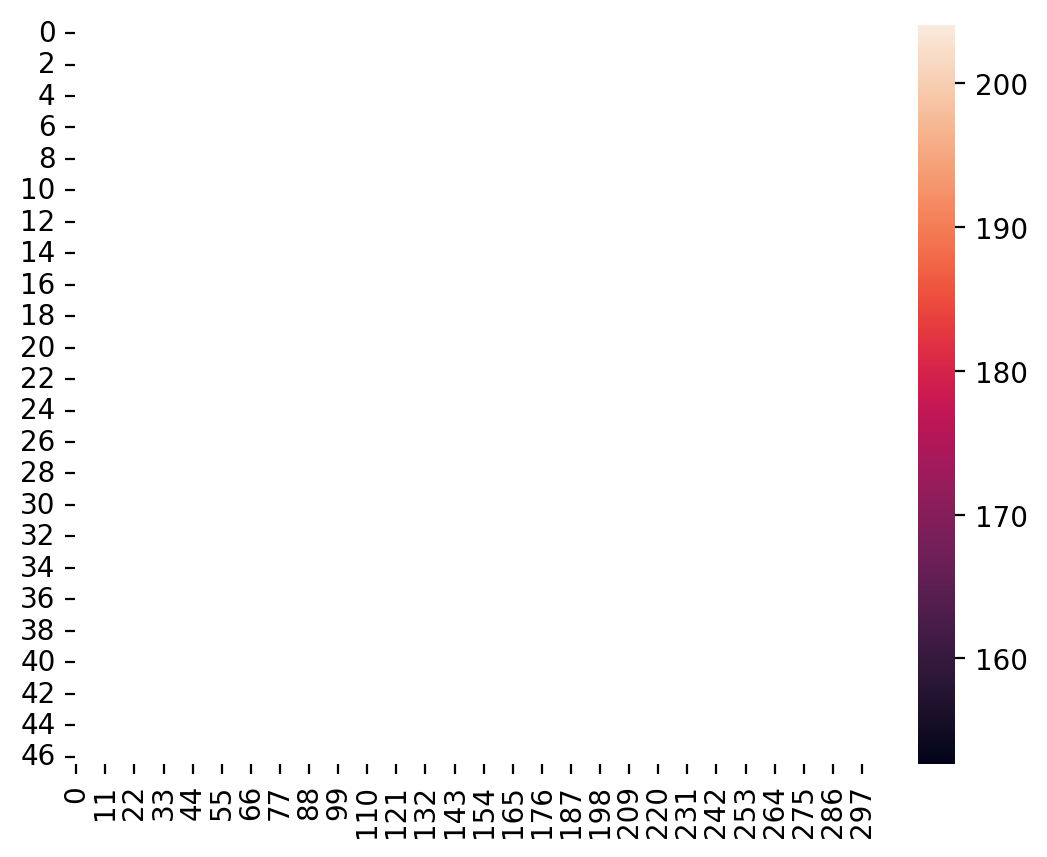

In [ ]:
a = tmp2[1]
print(a.shape)
ax = sns.heatmap(a, linewidth=0.5)
plt.show()

## Print out the maks and save variables after modeling

In [ ]:
stop = ['drink', 'flavors', 'imported', 'made', 'best', 'finish',' aromas', 'notes']
#stop = []

sent_lengths = len(sentence_in)

tmp1 = mask_out.detach().numpy()[:,(pad_size -sent_lengths): ]
tmp2 = save_out.detach().numpy()[:,(pad_size -sent_lengths): ]

tmp1 = np.mean(tmp1,axis = 0)
tmp2 = np.mean(tmp2,axis = 0)
#tmp2 = tmp2 /np.linalg.norm(tmp2,ord=2)

tmp1 = np.round(tmp1,2)
tmp2 =np.round(tmp2,2)

for i, x in enumerate(sentence_in):
    if x in stop:
        tmp1[i] = 0.0
        tmp2[i] = -0.0

pd_out = pd.DataFrame([tmp1, tmp2]).T

pd_out['input'] =  sentence_in
print(pd_out[1].mean())
### remove
pd_out

14.783829


,0,1,input
0,0.19,38.130001,toffee
1,0.59,116.639999,aromas
2,0.00,0.010000,leads
3,0.00,0.820000,to
4,0.01,1.600000,a
5,0.00,0.050000,complex
6,0.00,0.090000,array
7,0.02,2.830000,of
8,0.54,105.269997,fig
9,0.03,5.340000,mineral


## Display the Synthesizer Architecture

In [ ]:
print(mb31)

Synthesizer(
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): tiedLinear()
  (fc1): tiedLinear()
  (attention): SelfAttention(
    (tokeys): Linear(in_features=300, out_features=300, bias=False)
    (toqueries): Linear(in_features=300, out_features=300, bias=False)
    (tovalues): Linear(in_features=300, out_features=300, bias=False)
    (unifyheads): Linear(in_features=300, out_features=300, bias=True)
  )
  (fc3): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (sig): Sigmoid()
  (tanh): Tanh()
)


In [ ]:
use_mask = True
embeds, mask_1= mb01(texts)

mask_out, p1, p3,mean_mask = mb21(embeds,mask_1, digits)
#mb11.register_forward_hook(get_activation('attention1'))
sent_out, sents, sents0 = mb11(embeds,mask_1, mask_out, digits)
output , p2, save_out = mb31(sent_out, digits, mask_out,use_mask )

## Define activation functions

In [ ]:
activation = {}
activation1 = {}
activation2 = {}
activation3 = {}
activation4 = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_activation1(name):
    def hook(model, input, output):
        activation1[name] = output.detach()
    return hook
def get_activation2(name):
    def hook(model, input, output):
        activation2[name] = output.detach()
    return hook
def get_activation3(name):
    def hook(model, input, output):
        activation3[name] = output.detach()
    return hook
def get_activation4(name):
    def hook(model, input, output):
        activation4[name] = output.detach()
    return hook

## Try one sentence for attention register forward hook

In [ ]:
sentence = 'this lush beauty really tames the rugged structure of the vintage offering gorgeous boysenberry and raspberry layered with mocha turkish coffee licorice and fig paste notes the long finish has great grip though it is remarkably well embedded allowing the exotic spice notes to linger beautifully best from 2010 through 2030 1 665 cases made 50 cases imported'
#sentence = ds_out.Clean_desc.values[0]
sentence = re.sub(r'[^\w\s]', '', sentence)
sentence = sentence.lower().translate(string.punctuation)
sentence_in = []
sentence_in_id = []
out_words = []
for x in sentence.split():
    if new_vocab_dict.get(x):
      sentence_in.append(x)
      sentence_in_id.append(new_vocab_dict[x])
    else:
      out_words.append(x)

print(f"{out_words} are not in the vocabulary")
print(f"{sentence_in} are taken as input")

padded_X = pad_features([sentence_in_id], pad_size)

train_x  = np.concatenate([padded_X, np.expand_dims(np.array([len(sentence_in)]), axis=1)],axis=1 )
train_x = torch.LongTensor(np.repeat(train_x, batch_size, axis=0))
texts, digits = train_x[:,0:pad_size], train_x[:,pad_size:(pad_size + 2)]


use_mask = True
embeds, mask_1= mb01(texts)

mask_out, p1, p3,mean_mask = mb21(embeds,mask_1, digits)

#mb11.register_forward_hook(get_activation('attention1'))
mb11.attention1.register_forward_hook(get_activation1('tokeys'))
mb11.attention1.register_forward_hook(get_activation2('toqueries'))
mb11.attention1.register_forward_hook(get_activation3('tovalues'))
sent_out, sents, sents0 = mb11(embeds, mask_1, mask_out, digits)

output , p2, save_out = mb31(sent_out, digits, mask_out,use_mask )
mb31.attention.register_forward_hook(get_activation4('unifyheads'))

[] are not in the vocabulary
['this', 'lush', 'beauty', 'really', 'tames', 'the', 'rugged', 'structure', 'of', 'the', 'vintage', 'offering', 'gorgeous', 'boysenberry', 'and', 'raspberry', 'layered', 'with', 'mocha', 'turkish', 'coffee', 'licorice', 'and', 'fig', 'paste', 'notes', 'the', 'long', 'finish', 'has', 'great', 'grip', 'though', 'it', 'is', 'remarkably', 'well', 'embedded', 'allowing', 'the', 'exotic', 'spice', 'notes', 'to', 'linger', 'beautifully', 'best', 'from', '2010', 'through', '2030', '1', '665', 'cases', 'made', '50', 'cases', 'imported'] are taken as input


## Heatmap for tokens and their word embeddings

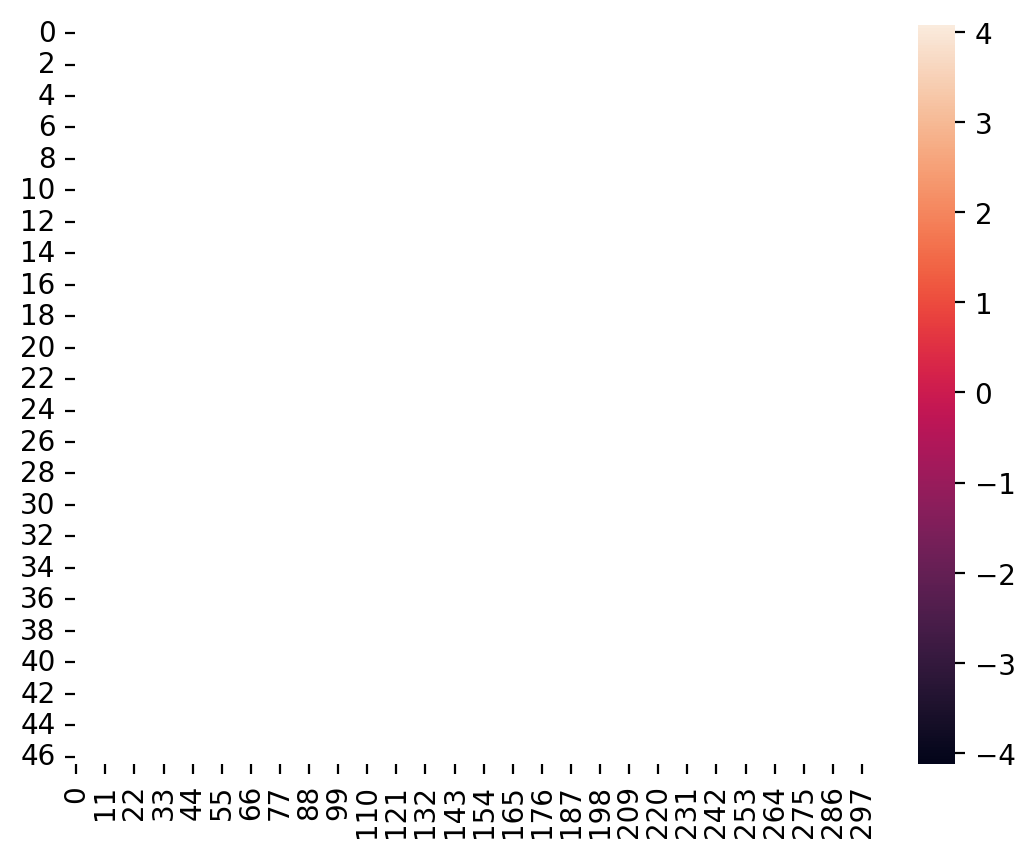

In [ ]:
tmp1 = sents0.detach().numpy()[:,(pad_size -sent_lengths):,: ]
stop = ['drink', 'flavors', 'imported', 'made', 'best','finish','aromas','notes']
#stop = []

a = tmp1[1]
ax = sns.heatmap(a, linewidth=0.5)
plt.show()

## Try a random matrix for heat map

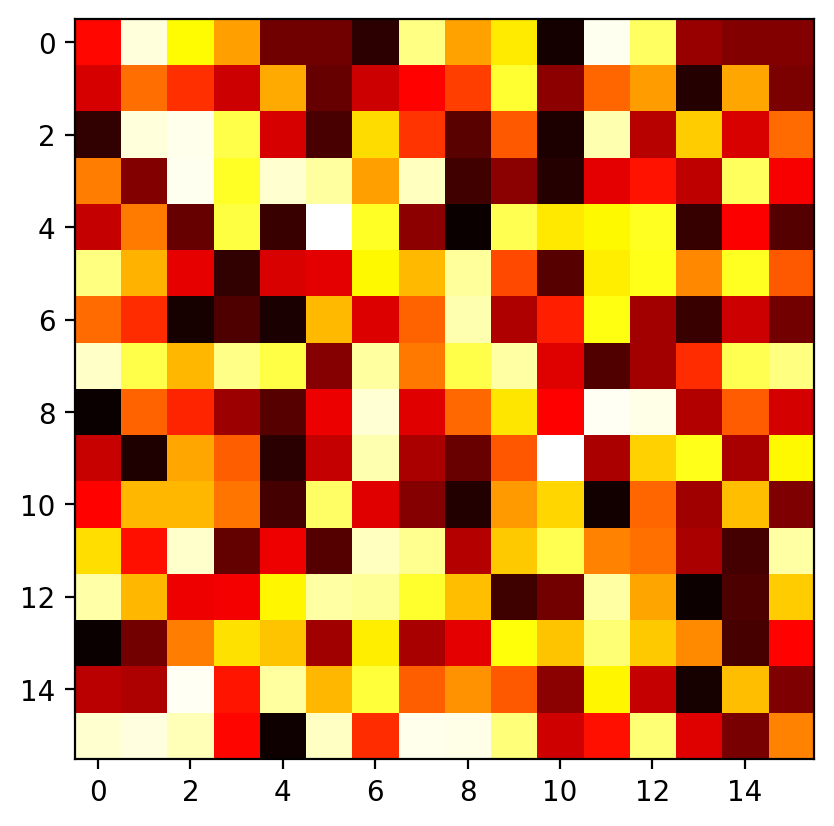

In [ ]:
a = np.random.random((16, 16))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

## Extract keys, queries, and values

In [ ]:
keys = activation1['tokeys']
queries = activation2['toqueries']
values = activation3['tovalues']
#attention_out = activation4['unifyheads']

In [ ]:
b, t, e = keys.size()
h=10
s = e//h
keys    = keys.view(b, t, h, s)
queries = queries.view(b, t, h, s)
values  = values.view(b, t, h, s)

In [ ]:
keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
values = values.transpose(1, 2).contiguous().view(b * h, t, s)

queries = queries / (e ** (1/4))
keys    = keys / (e ** (1/4))
# - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
#   This should be more memory efficient

# - get dot product of queries and keys, and scale
dot = torch.bmm(queries, keys.transpose(1, 2))
print(dot.shape)
print(torch.bmm(dot, values).shape)

torch.Size([640, 100, 100])
torch.Size([640, 100, 30])


In [ ]:
dot = F.softmax(dot, dim=2)
# - dot now has row-wise self-attention probabilities
print(dot.shape)

# apply the self attention to the values
out = torch.bmm(dot, values).view(b, h, t, s)
out1 = out.view(b, t, s * h)

torch.Size([640, 100, 100])


In [ ]:
dot[64][0]
out[0].shape
output = out[0][0][(pad_size -sent_lengths):]
out1[0][(pad_size -sent_lengths)+7].sum()

tensor(-5.6889)

In [ ]:
stop = ['drink', 'flavors', 'imported', 'made', 'best','finish','aromas','notes']
#stop = []

sent_lengths = len(sentence_in)

tmp1 = mask_out.detach().numpy()[:,(pad_size -sent_lengths): ]
tmp2 = save_out.detach().numpy()[:,(pad_size -sent_lengths): ]

tmp1 = np.mean(tmp1,axis = 0)
tmp2 = np.mean(tmp2,axis = 0)
#tmp2 = tmp2 /np.linalg.norm(tmp2,ord=2)

tmp1 = np.round(tmp1,2)
tmp2 =np.round(tmp2,2)

for i, x in enumerate(sentence_in):
    if x in stop:
        tmp1[i] =0.0
        tmp2[i]= -0.0

pd_out = pd.DataFrame([tmp1,tmp2]).T

pd_out['input'] =  sentence_in
print(pd_out[1].mean())
### remove
print(pd_out.head())

17.201551
      0      1   input
0  0.00   0.20    this
1  0.12  24.17    lush
2  0.07  14.42  beauty
3  0.00   0.30  really
4  0.00   0.00   tames


In [ ]:
use_mask = True
embeds , mask_1= mb01(texts)

mask_out, p1, p3,mean_mask = mb21(embeds,mask_1, digits)
sent_out, sents, sents0 = mb11(embeds, mask_1, mask_out, digits)


output , p2, save_out = mb31(sent_out, digits, mask_out,use_mask )

mask_out = mask_out.detach()

masks.append(mean_mask)
mask_out = mask_out.detach().to('cpu').numpy()
save_out = save_out.detach().to('cpu').numpy()
inputs_tmp = inputs.to('cpu').numpy()

# Result Analysis

In [ ]:
whole_word_pred = train_word_pred + val_word_pred +test_word_pred
whole_mask_pred = train_mask_pred + val_mask_pred +test_mask_pred
### scale to -5 to 5
mean_sent = whole_word_pred[:,0]/whole_word_pred[:,1]

<ipython-input-82-405a11e4506b>:4: RuntimeWarning: invalid value encountered in divide
  mean_sent = whole_word_pred[:,0]/whole_word_pred[:,1]


In [ ]:
whole_mask_pred

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
#masks_ = train_mask_counter[epoch-1 ,:,0]/(train_mask_counter[epoch-1,:,1]+train_mask_counter[epoch-1,:,0]+1e-8)
masks_ = whole_mask_pred [:,0]/np.sum(whole_mask_pred + 1e8,axis =1 )
masks_ = np.nan_to_num(masks_)
n = 2000
top_mask_n =np.argsort(masks_)[::-1][:n]
top_mask_n_word = [new_vocab_id2word[x] for x in top_mask_n]

output_mask = top_mask_n_word

In [ ]:
masks_

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
top_mask_n_word[0:40]

['toscana',
 '589',
 'lightness',
 'raciness',
 "'86",
 'vineyards',
 'favor',
 '772',
 'ruggedly',
 '86',
 "'09",
 'completely',
 'trimmer',
 'evolution',
 'enmeshed',
 'luce',
 'overpowering',
 'rendering',
 '883',
 'sophistication',
 'chave',
 '935',
 'reverberates',
 '636',
 '716',
 '677',
 'shares',
 'gripped',
 'evolving',
 'appropriately',
 'pedigree',
 '523',
 'prosciutto',
 'applewood',
 'overlaying',
 'heralds',
 'racier',
 '744',
 'geranium',
 'yielding']

## Display the distributions (percentage) of important words across Corpus of each rating

selected word is "toscana", 0th in output
selected word is "589", 1th in output
selected word is "lightness", 2th in output
selected word is "raciness", 3th in output
selected word is "'86", 4th in output
selected word is "vineyards", 5th in output
selected word is "favor", 6th in output
selected word is "772", 7th in output
selected word is "ruggedly", 8th in output
selected word is "86", 9th in output
selected word is "'09", 10th in output
selected word is "completely", 11th in output


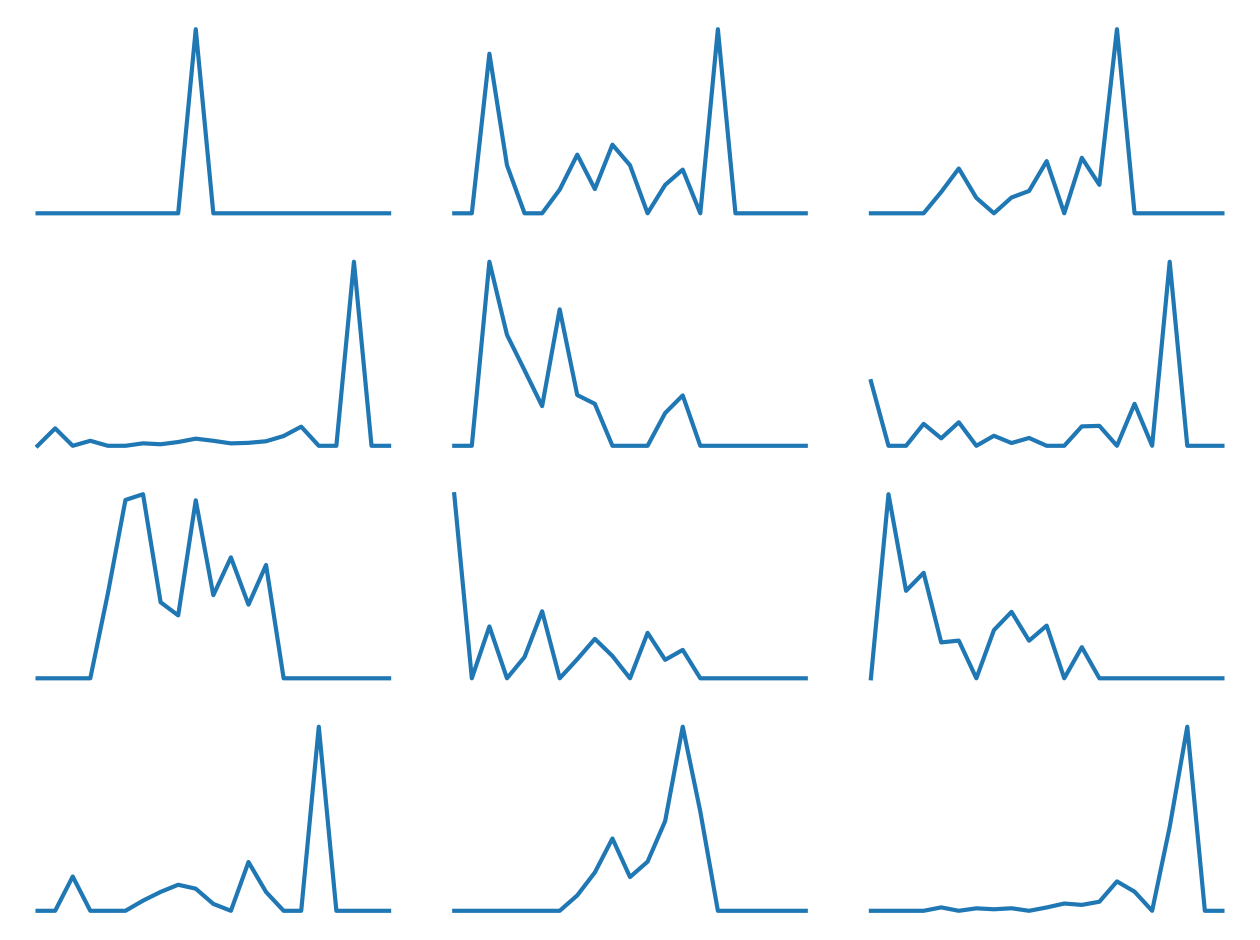

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3)

for ip, ax in enumerate(axes.ravel()): # or axes.flatten() or axes.flat
    word = output_mask[ip]
    print(f"selected word is \"{word}\", {ip}th in output")
    ids = new_vocab_dict.get(word)
    tmp = [ids in doc for doc in Corpus_cleaned_id]
    ratings = ds['rating']
    unique_rating = np.unique(ratings,return_counts=True)
    percents=[]
    abs_freq=[]
    for j,x in enumerate(unique_rating[0]):
        tmp1 = 0
        for i1,i2 in enumerate(ratings):
            if x==i2 and tmp[i1]:
                tmp1+=1
        tmp1/=unique_rating[1][j]
        percents.append(tmp1)


    sns.lineplot(x=list(range(80,101)), y=percents, ax=ax)
    ax.axis('off')
    plt.tight_layout() # To get a better spacing between the subplots

In [ ]:
val_word_pred[436]
mean_sent[581]
new_vocab_dict['gorgeous']

579

In [ ]:
whole_word_pred = train_word_pred + val_word_pred +test_word_pred
### scale to -5 to 5
mean_sent = whole_word_pred[:,0]/whole_word_pred[:,1]

<ipython-input-89-4e0adf3aba04>:3: RuntimeWarning: invalid value encountered in divide
  mean_sent = whole_word_pred[:,0]/whole_word_pred[:,1]


In [ ]:
mean_sent[mean_sent>0] /=( 27/5)
mean_sent[mean_sent<0] /= (38/5)

In [ ]:
#mean_sent = test_word_pred[:,0]/test_word_pred[:,1]
#mean_sent = val_word_pred[:,0]/val_word_pred[:,1]
#mean_sent = test_value_pred[:,0]/test_value_pred[:,1]
#mean_sent = train_word_pred[:,0]/train_word_pred[:,1]

#mean_sent = val_word_pred[:,0]/val_word_pred[:,1]
mean_sent = np.nan_to_num(mean_sent)
n =1000
#add or delete the negative operator in front of 1 in the next two lines
#to adjust polarity of output
top_n=np.argsort(mean_sent)[::1][:n]
top_n_value = np.sort(np.around(mean_sent,4))[::1][:n]
top_n_word = [new_vocab_id2word[x] for x in top_n if x in new_vocab_id2word]
output = top_n_word
output_dict = dict(zip(top_n_word,top_n_value))

In [ ]:
# index=141896
# texts = Corpus_cleaned[index]
# ids =  Corpus_cleaned_id[index]
# print(texts[0:16])
# mask_rate =[np.around(masks_[x],2) for x in ids]
# # mask_rate = [1,1,0,1,1,
# #              0,1,0,1,1,
# #              1,0,0,0,0,
# #              1]
# print(mask_rate[0:16])
# [np.around(masks_[x],2) for x in ids]
# results = pd.DataFrame(texts[0:16])
# sent_score = [np.around(mean_sent[x],2) for x in ids]
# results['(un)mask'] = mask_rate[0:16]
# results['sentiment_value'] = sent_score[0:16]

## Display the distributions (percentage) of important words across Corpus of each rating

selected word is "valette(0.0)", 0th in output
selected word is "fontaine(0.0)", 1th in output
selected word is "galego(0.0)", 2th in output
selected word is "structurally(0.0)", 3th in output
selected word is "shyly(0.0)", 4th in output
selected word is "cauldron(0.0)", 5th in output
selected word is "tower(0.0)", 6th in output
selected word is "cousins(0.0)", 7th in output
selected word is "biggest(0.0)", 8th in output
selected word is "roasting(0.0)", 9th in output
selected word is "encircling(0.0)", 10th in output
selected word is "slows(0.0)", 11th in output
selected word is "lustrous(0.0)", 12th in output
selected word is "forsake(0.0)", 13th in output
selected word is "cylinders(0.0)", 14th in output
selected word is "whatever(0.0)", 15th in output
selected word is "fingers(0.0)", 16th in output
selected word is "teasingly(0.0)", 17th in output
selected word is "juiced(0.0)", 18th in output
selected word is "litchi(0.0)", 19th in output


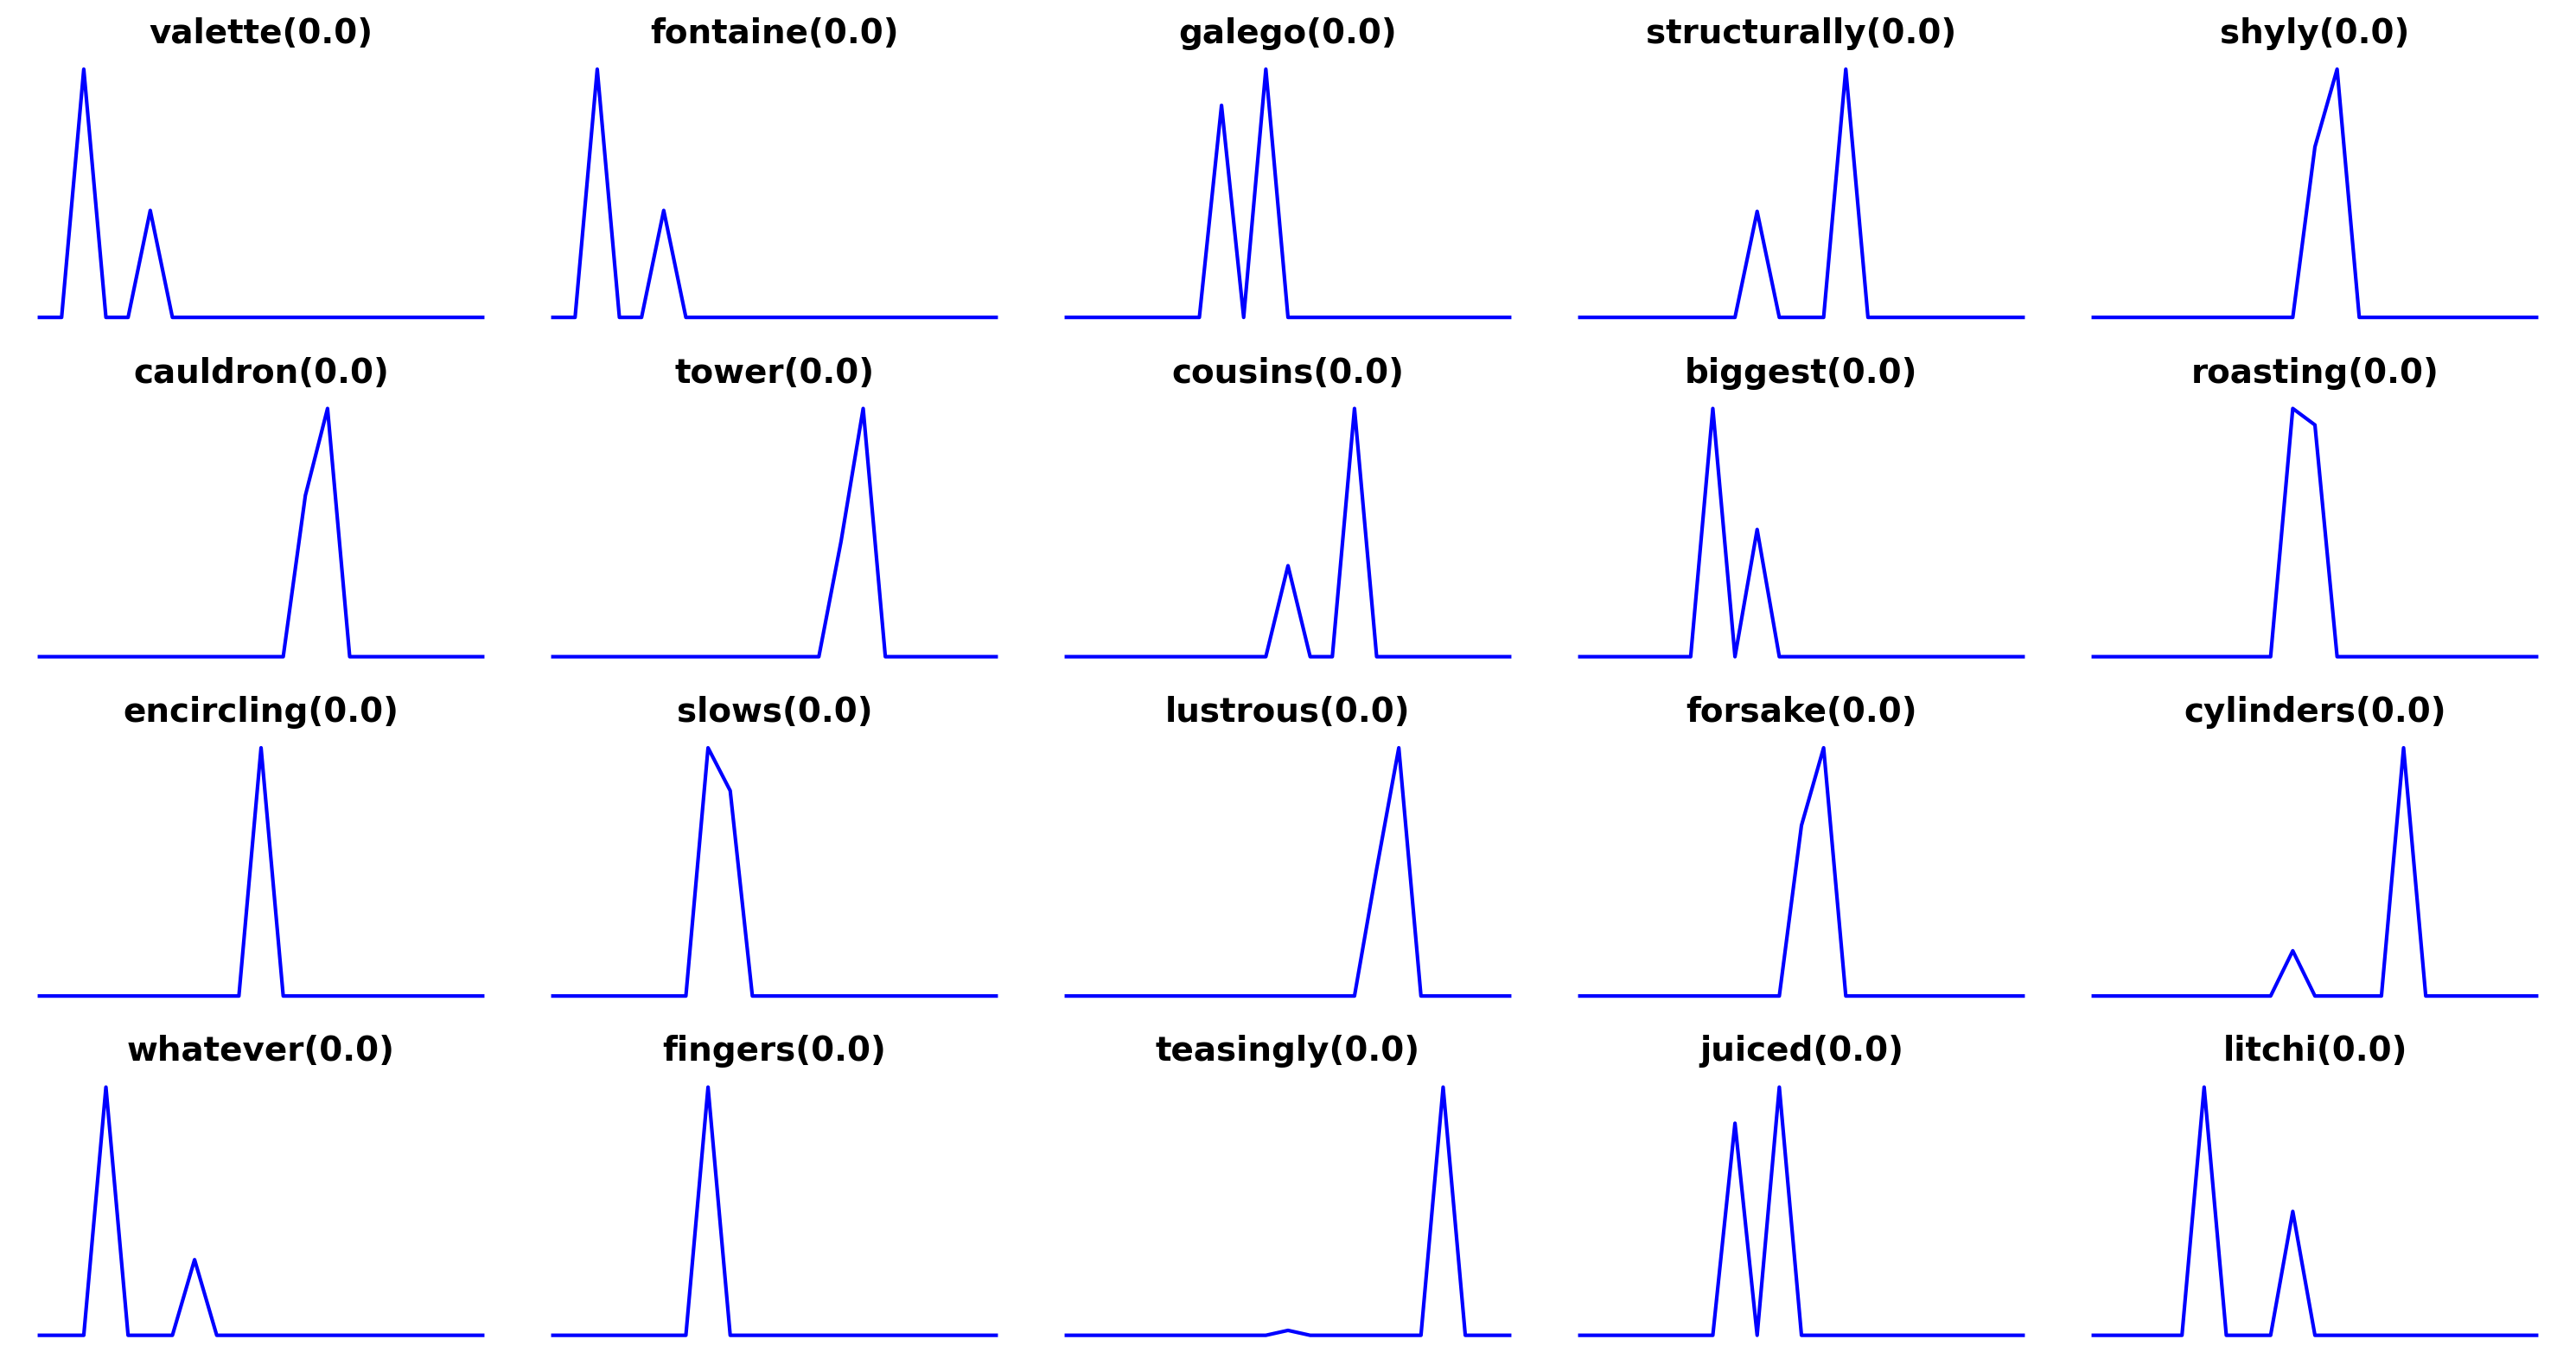

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5,figsize=(15,8))

for ip, ax in enumerate(axes.ravel()): # or axes.flatten() or axes.flat
    word = output[ip]
    print(f"selected word is \"{word}({np.around(output_dict[word],1)})\", {ip}th in output")
    ids = new_vocab_dict.get(word)
    tmp = [ids in doc for doc in Corpus_cleaned_id]
    ratings = ds['rating']
    unique_rating = np.unique(ratings,return_counts=True)
    percents=[]
    abs_freq=[]
    for j,x in enumerate(unique_rating[0]):
        tmp1 = 0
        for i1,i2 in enumerate(ratings):
            if x==i2 and tmp[i1]:
                tmp1+=1
        tmp1/=unique_rating[1][j]
        percents.append(tmp1)


    ax.set_title(f"{word}({np.around(output_dict[word],1)})",fontdict={'fontsize': 14,'fontweight':'bold'})
    ax.axis('off')
    ax.plot(list(range(80,101)), percents, color="blue")
    plt.tight_layout() # To get a better spacing between the subplots

## Count word freqeuncy and find words that appear more than 10 times

In [ ]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
# Join all words into sentences
corpus = [' '.join(x) for x in Corpus_cleaned]
# Initialize a count object
Count_model  = CountVectorizer()
# Fit to the data
Count_vector = Count_model.fit_transform(corpus)


counts = np.sum(Count_vector,axis=0).squeeze()
counts = counts.reshape(counts.shape[1])
counts = np.array(counts)
counts=np.squeeze(counts)

names = Count_model.get_feature_names_out()
selected_names=[]
for i, x in enumerate((counts >10)):
    if x:
        selected_names.append(names[i])
print(len(selected_names))
print(selected_names[:10])
selected_words = []
for item in selected_names:
    try:
        selected_words.append(int(item))
    except ValueError:
        continue
selected_wordsss = [new_vocab_id2word.get(x) for x in selected_words]
#output = [x for x in output if x in output_mask]
#output1 = [x for x in output if x in selected_names and not str(x).isdigit()]
output1 = [x for x in output if x in selected_wordsss]
#output.remove('cases')
#output.remove('medium')
print(output)
print(selected_wordsss)
print(output1)

4658
['000', '004', '005', '006', '008', '010', '0100', '012', '013', '015']
['valette', 'fontaine', 'galego', 'structurally', 'shyly', 'cauldron', 'tower', 'cousins', 'biggest', 'roasting', 'encircling', 'slows', 'lustrous', 'forsake', 'cylinders', 'whatever', 'fingers', 'teasingly', 'juiced', 'litchi', 'orbiting', 'aerated', 'outsized', 'questionable', 'dosage', 'suffuse', 'crusted', 'someone', 'sows', '0750', 'nonsense', 'prolong', 'replaced', 'hardy', 'buildup', 'colorado', 'nodding', 'shafer', 'challenge', 'chocolatey', 'flurry', 'muscatel', 'indicated', 'browning', 'russet', 'gilette', 'focal', 'unvarnished', 'protrudes', 'whip', 'tall', 'jaune', 'literally', 'valiantly', 'excite', 'sprig', 'remnants', 'repay', 'beach', 'ringer', 'nettle', 'ballerina', 'tint', 'tradition', 'rub', 'raciest', 'bourgueil', 'wildly', 'meredith', 'glimmers', 'american', 'twangy', 'regard', 'kafir', 'disarming', 'montelena', 'mellowness', '0650', 'middleweight', 'uninteresting', 'enthralling', 'horizon

## Need value.txt, words.txt, selectword.txt

In [ ]:
with open('/users/chenyuy/mir_output/value.txt') as f:
    lines = f.readlines()
tmp_v =[]
for x in lines:
    tmp_v.append(eval(x.strip()))
tmp_v.pop(0)
with open('/users/chenyuy/mir_output/words.txt') as f:
    lines = f.readlines()
tmp_w =[]

for x in lines:
    qq = x.strip()
    qq = qq.replace('"', '')
    tmp_w.append(qq)
tmp_w = tmp_w

with open('/users/chenyuy/mir_output/selectword.txt') as f:
    lines = f.readlines()
selected_names =[]

for x in lines:
    qq = x.strip()
    qq = qq.replace('"', '')
    selected_names.append(qq)

FileNotFoundError: [Errno 2] No such file or directory: '/users/chenyuy/mir_output/value.txt'

In [ ]:
mir_dictionary = dict(zip(tmp_w,tmp_v))
outputword = [x for x in tmp_w if x in selected_names]

In [ ]:
tmp = output1[0:100]
tmp1 = []
for i,x in enumerate(tmp):
   # x = x + f'({np.round(output_dict[tmp[i]],1)})'
   # qq = '\\' + 'textcolor{' + f'{temp_cat[i]}' +'}{'
  #  qq = qq +  '\\' + 'size{' + f'{np.round(output_dict[tmp[i]]/3+5,1)}' +'}{'+  x  +'}'  +'}'
   # qq = qq +  '\\' + 'size{' + f'{np.round(-output_dict[tmp[i]]/3+2,1)}' +'}{'+  x  +'}'  +'}'
   # qq =  '\\' + 'size{' + f'{-np.round(output_dict[tmp[i]]/2+5,1)}' +'}{'+  x  +'}'
    qq =  '\\' + 'textcolor{' + f'{temp_cat[i]}' +'}{' + x  +'}'
    tmp1.append(qq)
    if (i+1)%5!=0:
        tmp1.append(r'&')
    else:
        tmp1.append(r'\\')

print(' '.join(tmp1))

In [ ]:
tmp_mir = outputword[::-1][0:100]
tmp1_mir = []
for i,x in enumerate(tmp_mir):
 #   qq = '\\' + 'textcolor{' + f'{temp_cat_mir[i]}' +'}{'

 #   qq = qq +  '\\' + 'size{' + f'{np.round(-mir_dictionary[tmp_mir[i]]*1.3+5,1)}' +'}{'+  x  +'}'  +'}'
    qq = '\\' + 'textcolor{' + f'{temp_cat_mir[i]}' +'}{'   +  x  +'}'
    tmp1_mir.append(qq)
    if (i+1)%5!=0:
        tmp1_mir.append(r'&')
    else:
        tmp1_mir.append(r'\\')

print(' '.join(tmp1_mir))

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
lemmatizer = WordNetLemmatizer()
wnl = WordNetLemmatizer()
from pywsd.utils import lemmatize_sentence

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tmp_l = [stemmer.stem(plural) for plural in tmp]
tmp_l = [stemmer.stem(plural) for plural in tmp_l]

tmp_mir_l = [stemmer.stem(plural) for plural in tmp_mir]
tmp_mir_l = [stemmer.stem(plural) for plural in tmp_mir_l]


In [ ]:
temp_cat_mir = []

for x in tmp_mir_l:
    if x in tmp_l:
        temp_cat_mir.append('black')
    else:
        temp_cat_mir.append('blue')


In [ ]:
temp_cat = []
for x in tmp_l:
    if x in tmp_mir_l:
        temp_cat.append('black')
    else:
        temp_cat.append('red')


In [ ]:
tmp = output1[0:50]
tmp1 = []
for i,x in enumerate(tmp):
   # x = x + f'({np.round(output_dict[tmp[i]],1)})'
    qq = '\\' + 'textcolor{' + f'{temp_cat[i]}' +'}{'

    #qq = qq +  '\\' + 'size{' + f'{np.round(output_dict[tmp[i]]/3+5,1)}' +'}{'+  x  +'}'  +'}'
    qq = qq +  '\\' + 'size{' + f'{np.round(-output_dict[tmp[i]]/3+2,1)}' +'}{'+  x  +'}'  +'}'
    tmp1.append(qq)
    if (i+1)%5!=0:
        tmp1.append(r'&')
    else:
        tmp1.append(r'\\')

print(' '.join(tmp1))

In [ ]:
import matplotlib.gridspec as gridspec
fig, axes = plt.subplots(nrows=4, ncols=5,figsize=(15,8))

for ip, ax in enumerate(axes.ravel()): # or axes.flatten() or axes.flat
    #word = output1[ip+40]
    word = outputword[ip+1]
    print(f"selected word is \"{word}({np.around(output_dict[word],1)})\", {ip}th in output")
    ids = new_vocab_dict.get(word)
    tmp = [ids in doc for doc in Corpus_cleaned_id]
    ratings = ds['rating']
    unique_rating = np.unique(ratings,return_counts=True)
    percents=[]
    abs_freq=[]
    for j,x in enumerate(unique_rating[0]):
        tmp1 = 0
        for i1,i2 in enumerate(ratings):
            if x==i2 and tmp[i1]:
                tmp1+=1
        tmp1/=unique_rating[1][j]
        percents.append(tmp1)

    ax.set_title(f"{word}({np.around(output_dict[word],1)})",fontdict={'fontsize': 14,'fontweight':'bold'})
    ax.axis('off')
    ax.plot(list(range(80,101)),percents, color="blue")
    plt.tight_layout() # To get a better spacing between the subplots

In [ ]:
output2 = [x for x in output if x in top_mask_n_word and not str(x).isdigit()]

In [ ]:
import matplotlib.gridspec as gridspec
fig, axes = plt.subplots(nrows=4, ncols=5,figsize=(15,8))

for ip, ax in enumerate(axes.ravel()): # or axes.flatten() or axes.flat
    word = output1[ip+20]
    print(f"selected word is \"{word}({np.around(output_dict[word],1)})\", {ip}th in output")
    ids = new_vocab_dict.get(word)
    tmp = [ids in doc for doc in Corpus_cleaned_id]
    ratings = ds['rating']
    unique_rating = np.unique(ratings,return_counts=True)
    percents=[]
    abs_freq=[]
    for j,x in enumerate(unique_rating[0]):
        tmp1 = 0
        for i1,i2 in enumerate(ratings):
            if x==i2 and tmp[i1]:
                tmp1+=1
        tmp1/=unique_rating[1][j]
        percents.append(tmp1)

    ax.set_title(f"{word}({np.round(output_dict[word])})",fontdict={'fontsize': 14,'fontweight':'bold'})
    ax.axis('off')
    ax.plot(list(range(80,101)),percents, color="blue")
    plt.tight_layout() # To get a better spacing between the subplots

In [ ]:
percents

In [ ]:
word = 'february'
ids = new_vocab_dict.get(word)
tmp = [ids in doc for doc in Corpus_cleaned_id]
ratings = ds['rating']
unique_rating = np.unique(ratings,return_counts=True)
percents=[]
abs_freq=[]
for j,x in enumerate(unique_rating[0]):
    tmp1 = 0
    for i1,i2 in enumerate(ratings):
        if x==i2 and tmp[i1]:
            tmp1+=1
    tmp1/=unique_rating[1][j]
    percents.append(tmp1)

plt.plot(list(range(80,101)),percents, color="blue")

#### pos tag


In [ ]:
from nltk import pos_tag
from nltk import word_tokenize
import nltk
nltk.download('punkt')

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
#tagged_texts = pos_tag(output1[0:500], tagset='universal')
tagged_texts = pos_tag(output1[0:500], tagset='universal')

In [ ]:
top_noun = []
for x in tagged_texts:
    if x[1] == 'NOUN':
        top_noun.append(x[0])


In [ ]:
train_word_dist_rat1[word_id]

In [ ]:
import seaborn as sns
word = 'labeled'
word_id = new_vocab_dict.get(word)
sns.histplot([train_word_dist_rat0[word_id],train_word_dist_rat1[word_id]],color = ['red','blue'],alpha = 0.7).set(title = word)

In [ ]:
mean_sent[word_id]

In [ ]:
word = 'hearted'
word_id = new_vocab_dict.get(word)
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle('1 row x 2 columns axes with no data')
sns.histplot(train_word_dist_rat0[word_id], color = ['blue'], ax =axes[1])
sns.histplot(train_word_dist_rat1[word_id], color = ['blue'], ax =axes[0])

In [ ]:
word = 'hearted'
word_id = new_vocab_dict.get(word)
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle('1 row x 2 columns axes with no data')
sns.histplot(train_word_dist_rat0[word_id], color = ['blue'], ax =axes[1])
sns.histplot(train_word_dist_rat1[word_id], color = ['blue'], ax =axes[0])

In [ ]:
len(train_word_dist_rat0[436])

In [ ]:

tmp = [" ".join(x) for x in Corpus_cleaned]
ds1 = pd.DataFrame(tmp)
ds1['labels'] = y
ds_out = ds1.loc[ds1[0].str.contains(" hearted ")]
idx  = 2
print(ds_out[0].iloc[idx])
print(ds_out['labels'].iloc[idx])

In [ ]:
ds_out

In [ ]:
ds_out = ds1[ds1[0].str.contains(" stain ")]
print(ds_out)

In [ ]:
pd.set_option('display.max_colwidth', 500)
ds_out.iloc[2]

In [ ]:
new_vocab_dict['friendly']

In [ ]:
print(val_word_pred[436])
val_mask_counter[436]

In [ ]:
len_0 =[len(x) for x in  train_word_dist_rat0]
len_1 =[len(x) for x in  train_word_dist_rat1]

In [ ]:
sent_tmp = 0
for x in tmp:
    sent_tmp += mean_sent[0]

sent_tmp

In [ ]:
np.sum([x<0 for x in preds])

In [ ]:
preds = []
for i in range(7095):
    tmp = valid_x[i]
    sent_tmp = 0
    for x in tmp:
        sent_tmp += mean_sent[x]

    preds.append(sent_tmp)


In [ ]:
len10ratio = []
len_sum = []
for i,x in enumerate(zip(len_0,len_1)):
    try:
        tmp = x[1]/x[0]
    except:
        tmp = 1e8
    len_sum.append(len_0[i] + len_1[i] )
    len10ratio.append(tmp)


In [ ]:
out_list = np.argsort(len10ratio)[::-1]
out_name = [new_vocab_id2word.get(x) for x in out_list]

[x for x in out_name if x in selected_names and not is.digit(x)]

In [ ]:
for x in np.argsort(len10ratio)[::-1][0:50]:
    print(new_vocab_id2word[x])

In [ ]:

print(f"selected word is \"{word}({np.around(output_dict[word],1)})\", {ip}th in output")
ids = new_vocab_dict.get(word)
tmp = [ids in doc for doc in Corpus_cleaned_id]
ratings = ds['rating']
unique_rating = np.unique(ratings,return_counts=True)
percents=[]
abs_freq=[]
for j,x in enumerate(unique_rating[0]):
    tmp1 = 0
    for i1,i2 in enumerate(ratings):
        if x==i2 and tmp[i1]:
            tmp1+=1
    tmp1
    percents.append(tmp1)


plt.plot(list(range(80,101)),percents, color="blue")
plt.title(f'Frequency of {word}')

In [ ]:
from numpy.lib.histograms import histogram
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=5,figsize=(15,8))
for ip, ax in enumerate(axes.ravel()): # or axes.flatten() or axes.flat
    word = output2[ip]
    word_id = new_vocab_dict.get(word)
    sns.histplot([val_word_dist_rat0[word_id],val_word_dist_rat1[word_id]],color = ['red','blue'],alpha = 0.5,ax=ax).set(title = word)

fig.subplots_adjust(wspace=0.3, hspace=0.6)

In [ ]:
from numpy.lib.histograms import histogram
import seaborn as sns


fig, axes = plt.subplots(nrows=4, ncols=5,figsize=(15,8))
for ip, ax in enumerate(axes.ravel()): # or axes.flatten() or axes.flat
    word = output2[ip]
    word_id = new_vocab_dict.get(word)
    sns.histplot([val_mask_dist_rat0[word_id],val_mask_dist_rat1[word_id]],color = ['red','blue'],alpha = 0.5,ax=ax)

In [ ]:
val_mask_dist_rat0[0]

In [ ]:
sig_qq = nn.Sigmoid()(torch.tensor(qq))
sns.distplot(sig_qq).set(title='sigmoid transformation')

In [ ]:
import matplotlib.gridspec as gridspec
fig, axes = plt.subplots(nrows=4, ncols=5,figsize=(15,8))

for ip, ax in enumerate(axes.ravel()): # or axes.flatten() or axes.flat
    word = output2[ip]
    print(f"selected word is \"{word}({np.around(output_dict[word],1)})\", {ip}th in output")
    ids = new_vocab_dict.get(word)
    tmp = [ids in doc for doc in Corpus_cleaned_id]
    ratings = ds['rating']
    unique_rating = np.unique(ratings,return_counts=True)
    percents=[]
    abs_freq=[]
    for j,x in enumerate(unique_rating[0]):
        tmp1 = 0
        for i1,i2 in enumerate(ratings):
            if x==i2 and tmp[i1]:
                tmp1+=1
        tmp1/=unique_rating[1][j]
        percents.append(tmp1)

    ax.set_title(f"{word}({np.around(output_dict[word],1)})",fontdict={'fontsize': 14,'fontweight':'bold'})
    ax.axis('off')
    ax.plot(list(range(80,101)),percents, color="blue")
    plt.tight_layout() # To get a better spacing between the subplots

In [ ]:
from matplotlib import colors
word = 'bubbly'
rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)

index = new_vocab_dict.get(word)

gg=sns.distplot(train_word_dist[index],color='red')
gg.set_title(f"zij distribution of '{word}'';  mask chance:{np.around(0.0,2)}")


In [ ]:
from matplotlib import colors
word = 'enticing'
rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)

index = new_vocab_dict.get(word)

gg=sns.distplot(train_word_dist[index],color='red')
gg.set_title(f"zij distribution of '{word}'';  mask chance:{np.around(0.0,2)}")

In [ ]:
qq = np.random.randn(1000)*1000
sns.distplot(qq).set(title='multiply by 1000')